In [1]:
%matplotlib inline

In [2]:
import urllib
import urllib2
import numpy as np
import datetime
import os
import pandas as pd
from scipy.integrate import simps
from sunpy.time import parse_time
import matplotlib.pyplot as plt

download AIA lightcurves, some attempts to plot AIA lightcurves

In [ ]:
def get_lightcurves_AIA(start_year, start_month, start_day, end_year, end_month, end_day, folder):
    day = datetime.datetime(start_year, start_month, start_day)
    end_time = datetime.datetime(end_year, end_month, end_day)
    delta_day = datetime.timedelta(days=1)
    while day <= end_time:
        day_str_slash = day.strftime('%Y/%m/%d')
        print day_str_slash
        day_str_underscore = day.strftime('%Y_%m_%d')
        url = 'http://sdowww.lmsal.com/sdomedia/SunInTime/'+day_str_slash+'/aia_light_curves.txt'
        fname = folder + '/' + day_str_underscore + '.txt'
        lightcurve = urllib2.urlopen(url).read()
        with open(fname, 'w') as text_file:
            text_file.write(lightcurve)
        day += delta_day

In [ ]:
get_lightcurves_AIA(2011, 1, 1, 2016, 6, 1, 'raw_AIA_lightcurves')

In [ ]:
fname = 'raw_AIA_lightcurves/2011_01_01.txt'
np.genfromtxt(fname, delimiter = '\t', names = True)

In [ ]:
def merge_AIA_lightcurves(f, folder):
    fname = folder+'/'+f
    lightcurve = pd.read_csv(fname, delim_whitespace = True, index_col=None, usecols = ['DATE_OBS','WAVELNTH','DATAMEAN'])
    return lightcurve

In [ ]:
for root, dirs, files in os.walk('raw_AIA_lightcurves'):
    i = 0
    listOfiles = []
    for f in files:
        if f[0] != '.':
            listOfiles.append(f)
            if i == 0:
                base_lightcurve = merge_AIA_lightcurves(f, 'raw_AIA_lightcurves')
            else:
                lightcurve = merge_AIA_lightcurves(f, 'raw_AIA_lightcurves')
                base_lightcurve = base_lightcurve.append(lightcurve, ignore_index = False)
            i+=1
base_lightcurve['DATE_OBS'] = map(lambda x: x[:-1], base_lightcurve['DATE_OBS'])
base_lightcurve.sort_values('DATE_OBS')
base_lightcurve.to_csv('raw_combined_AIA_lightcurves.csv', date_format = '%Y-%m-%dT%X', index = False)

In [ ]:
base_lightcurve = pd.read_csv('raw_AIA_lightcurves_combined.csv', delimiter = ',', header = 0)
base_lightcurve['DATE_OBS'] = map(lambda x: x[:-1], base_lightcurve['DATE_OBS'])
base_lightcurve['DATE_OBS'] = map(check60, base_lightcurve['DATE_OBS'])
base_lightcurve = base_lightcurve.sort_values('DATE_OBS')
base_lightcurve.to_csv('raw_combined_AIA_lightcurves1.csv', date_format = '%Y-%m-%dT%X', index = False)

In [ ]:
def check60(x):
    if x[-5:-3]==str(60):
        x = x[:-5]+str(59.99)
    return x

In [ ]:
platapus = '2011-01-01T00:04:60.00'
print platapus[-5:-3]
check60(platapus)

In [ ]:
unique_lambda = base_lightcurve.WAVELNTH.unique()
print list(unique_lambda)
# create a dictionary with unique NOAA numbers as keys 
lambda_dic = {elem : pd.DataFrame for elem in unique_lambda}
folder = 'lightcurves_AIA_by_wavelength'
for key in lambda_dic.keys():
    lambda_dic[key] = base_lightcurve[:][base_lightcurve.WAVELNTH == key]
    fName = str(key)
    location = folder + '/' + fName+ '.csv'
    lambda_dic[key].to_csv(location, index = False)


In [ ]:
def integrate_lightcurve_AIA_og(folder, wavelength, start_time, end_time):
    lightcurve_search = get_relevant_lightcurve_AIA(folder, wavelength, start_time, end_time)
    time_zero = start_time
    delta_t = lightcurve_search['DATE_OBS'] - time_zero
    delta_t = map(lambda x: int(x.total_seconds()), delta_t)
    integrated_flux = simps(lightcurve_search['DATAMEAN'], x = delta_t)
    return integrated_flux

In [ ]:
integrate_lightcurve_AIA_og('lightcurves_AIA_by_wavelength', 131, start_time, end_time)

In [ ]:
def get_relevant_lightcurve_AIA_og(folder, wavelength, start_time, end_time):
    fname = folder+'/'+str(wavelength)+'.csv'
    lightcurve = pd.read_csv(fname, delimiter = ',', header = 0)
    lightcurve['DATE_OBS'] = map(parse_time, lightcurve['DATE_OBS'])
    lightcurve_search = lightcurve.ix[lightcurve['DATE_OBS']>=start_time]
    lightcurve_search = lightcurve_search.ix[lightcurve_search['DATE_OBS']<=end_time]
    return lightcurve_search

In [ ]:
start_time = datetime.datetime(2012, 1, 1, 3, 23, 18)
end_time = datetime.datetime(2012, 1, 1, 14, 45, 13)

lc = get_relevant_lightcurve_AIA('lightcurves_AIA_by_wavelength', 131, start_time, end_time)

In [ ]:
time_zero = start_time
delta_t = lc['DATE_OBS'] - time_zero
flux = list(lc['DATAMEAN'])
plt.plot(delta_t, flux, color = 'black')
plt.show()

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


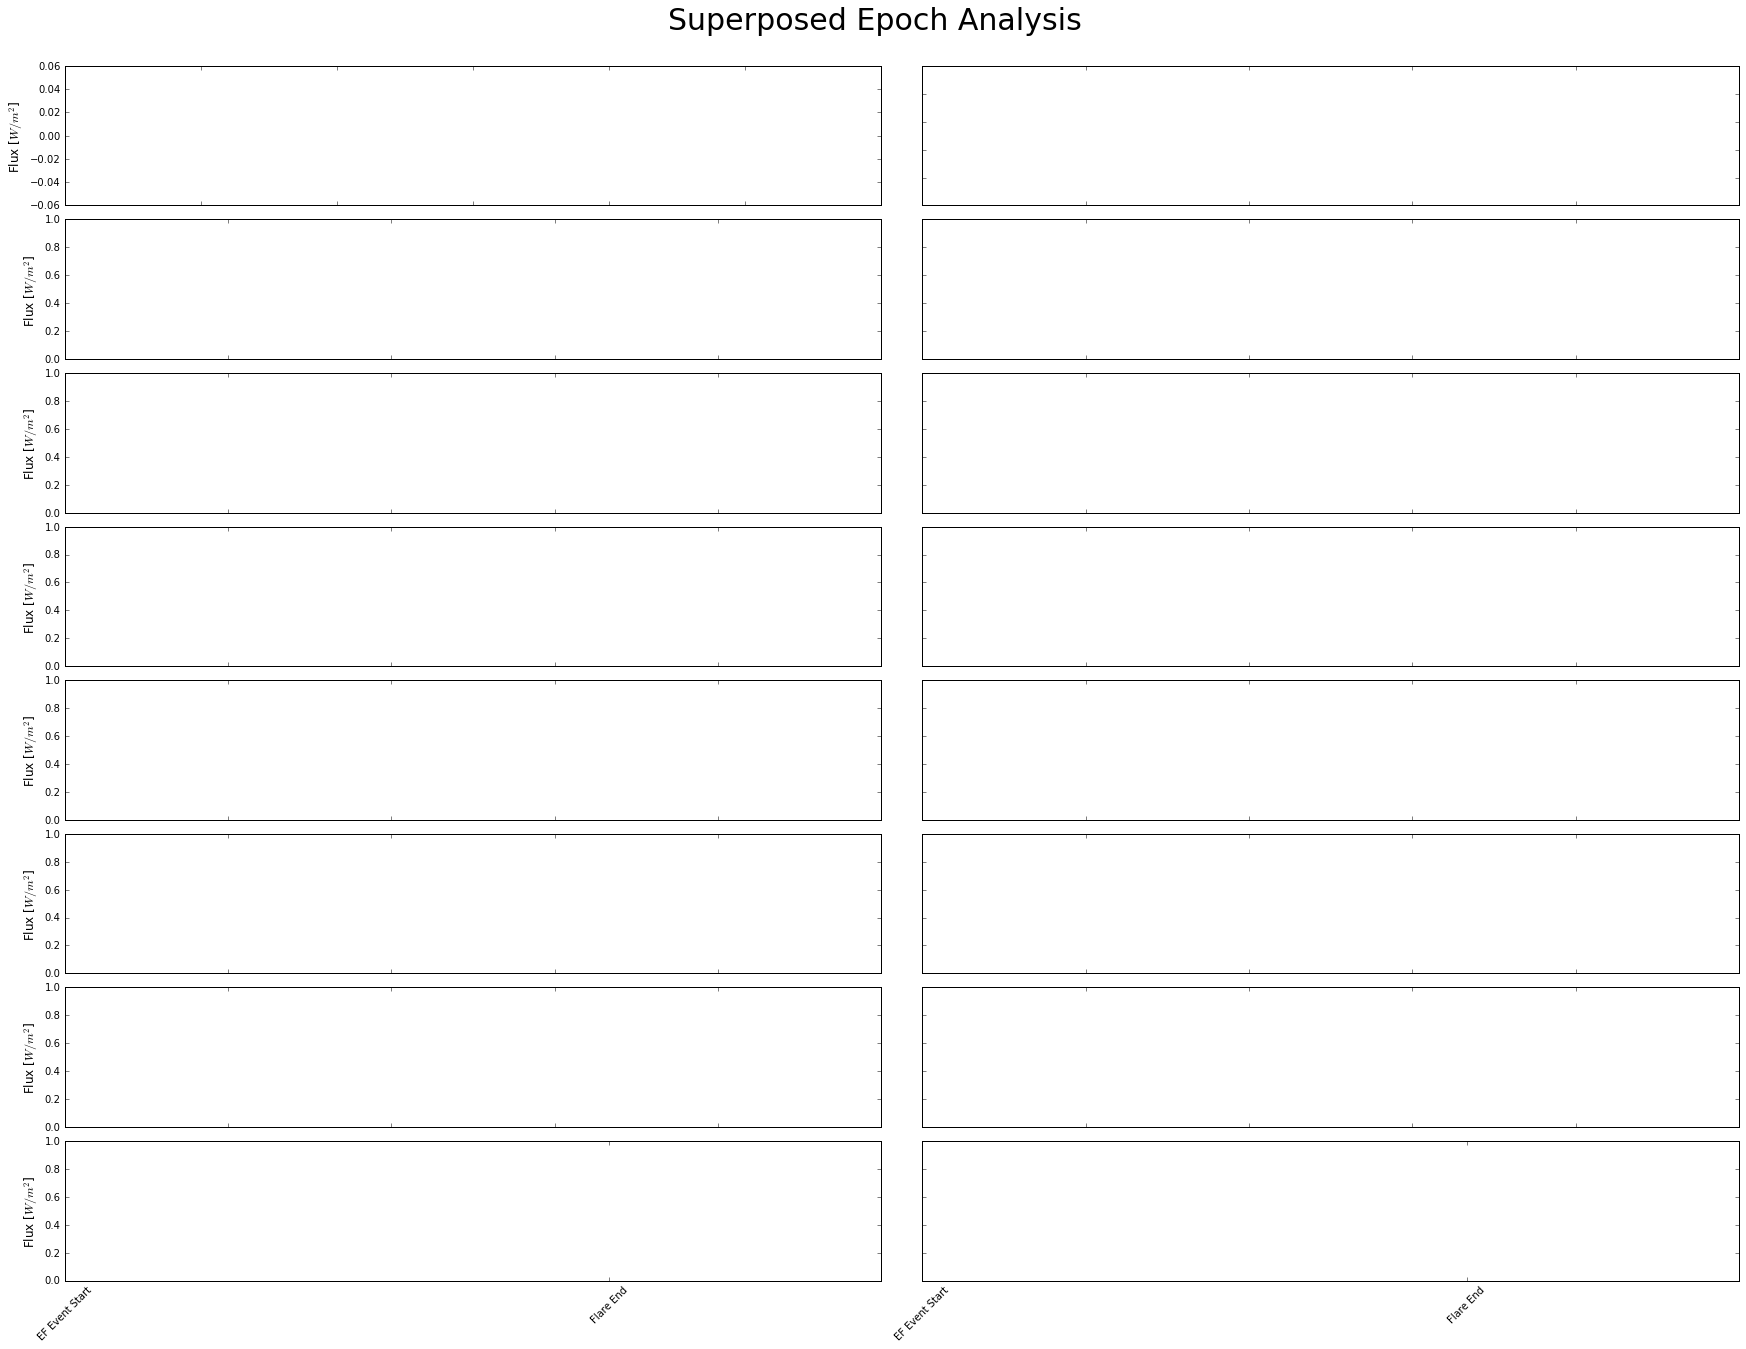

In [12]:
n = 30
axes = [('ax_goes1', 'ax_goes2'), ('ax_131a', 'ax_131b'), ('ax_094a', 'ax_094b'), ('ax_335a', 'ax_335b'), ('ax_211a', 'ax_211b'), 
            ('ax_193a', 'ax_193b'), ('ax_171a', 'ax_171b'), ('ax_304a', 'ax_304b')]
f, axes = (plt.subplots(8, 2, sharex = 'col', sharey = 'row', figsize = (30,20.7)))

#plt.title('Superposed Epoch Analysis', fontsize = 60)
colormap = plt.cm.jet
plt.suptitle('Superposed Epoch Analysis', fontsize = 30)
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9999, n)])
yLabel = r'Flux [$W/m^2$]'
transparency = np.linspace(0.4, 0.9, n)
j = -1

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0.05)
f.subplots_adjust(top=0.94)

plt.subplot(821)
plt.ylabel(yLabel, size = 'large')
plt.plot()

plt.subplot(822)
plt.yticks(visible = False)

plt.subplot(823)
plt.ylabel(yLabel, size = 'large')

plt.subplot(824)
plt.yticks(visible = False)

plt.subplot(825)
plt.ylabel(yLabel, size = 'large')

plt.subplot(826)
plt.yticks(visible = False)

plt.subplot(827)
plt.ylabel(yLabel, size = 'large')

plt.subplot(828)
plt.yticks(visible = False)

plt.subplot(829)
plt.ylabel(yLabel, size = 'large')

plt.subplot(8,2,10)
plt.yticks(visible = False)

plt.subplot(8,2,11)
plt.ylabel(yLabel, size = 'large')

plt.subplot(8,2,12)
plt.yticks(visible = False)

plt.subplot(8,2,13)
plt.ylabel(yLabel, size = 'large')

plt.subplot(8,2,14)
plt.yticks(visible = False)

plt.subplot(8,2,15)
_ = plt.xticks([0, 0.666667], ('EF Event Start', 'Flare End'), rotation = 45)
plt.ylabel(yLabel, size = 'large')

plt.subplot(8,2,16)
plt.yticks(visible = False)
_ = plt.xticks([0, 0.666667], ('EF Event Start', 'Flare End'), rotation = 45)

_ =plt.setp([a.get_xticklabels() for a in f.axes[:-2]], visible=False)



/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

0


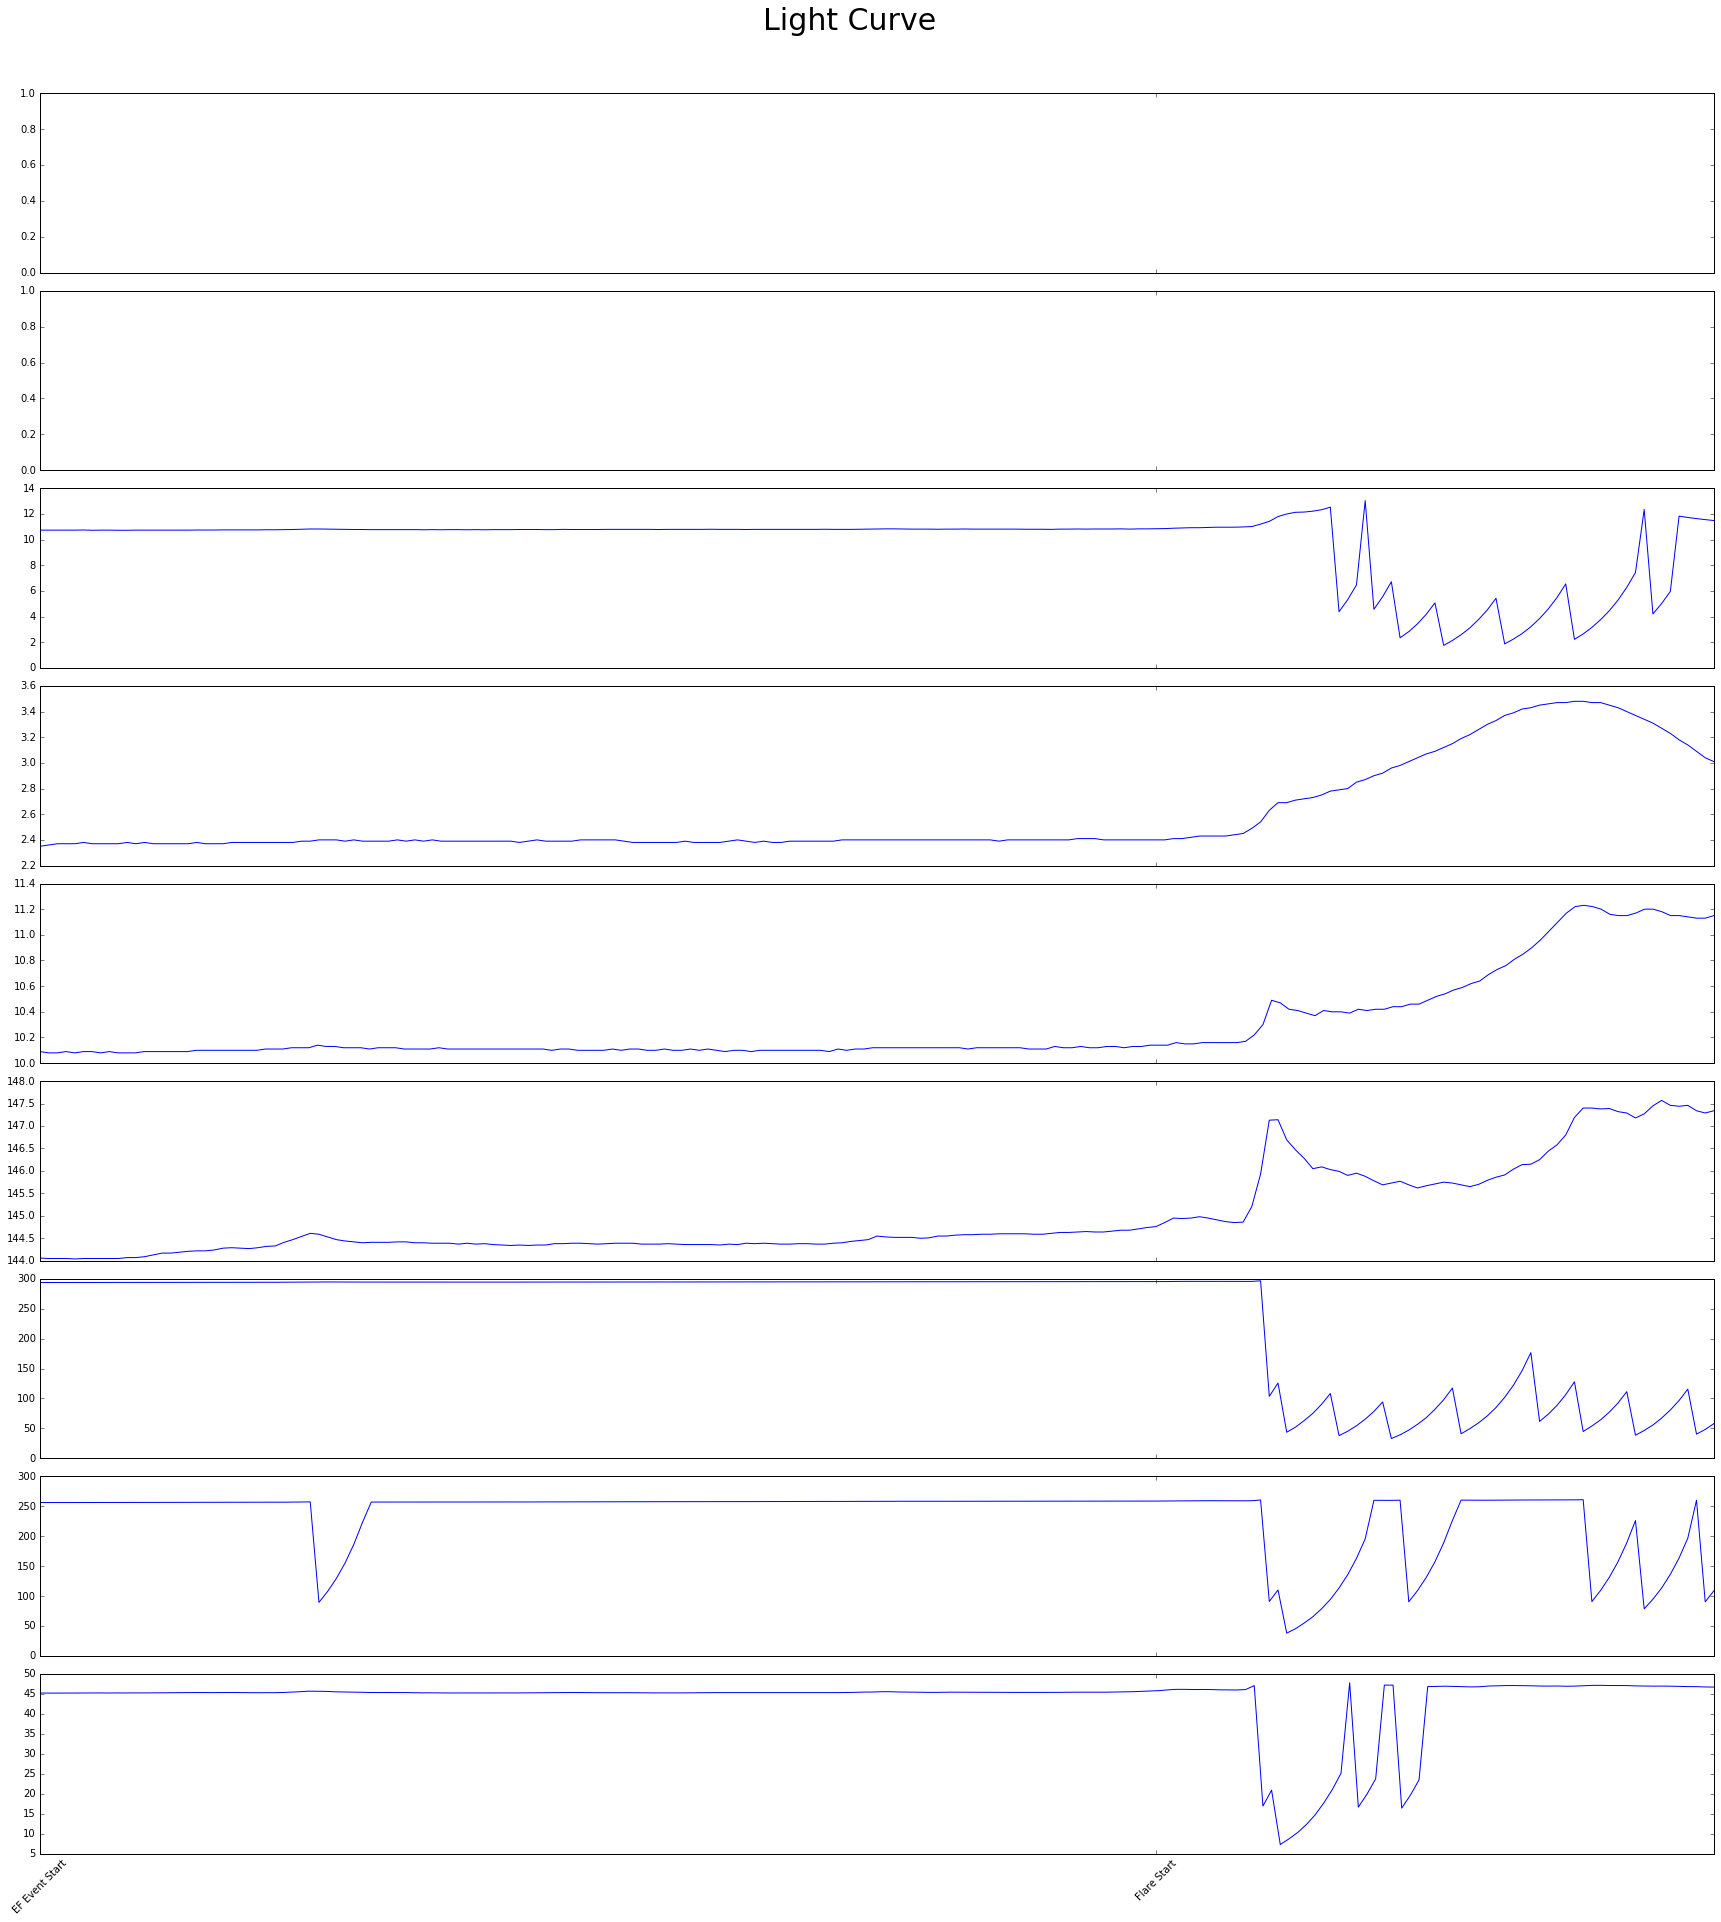

1


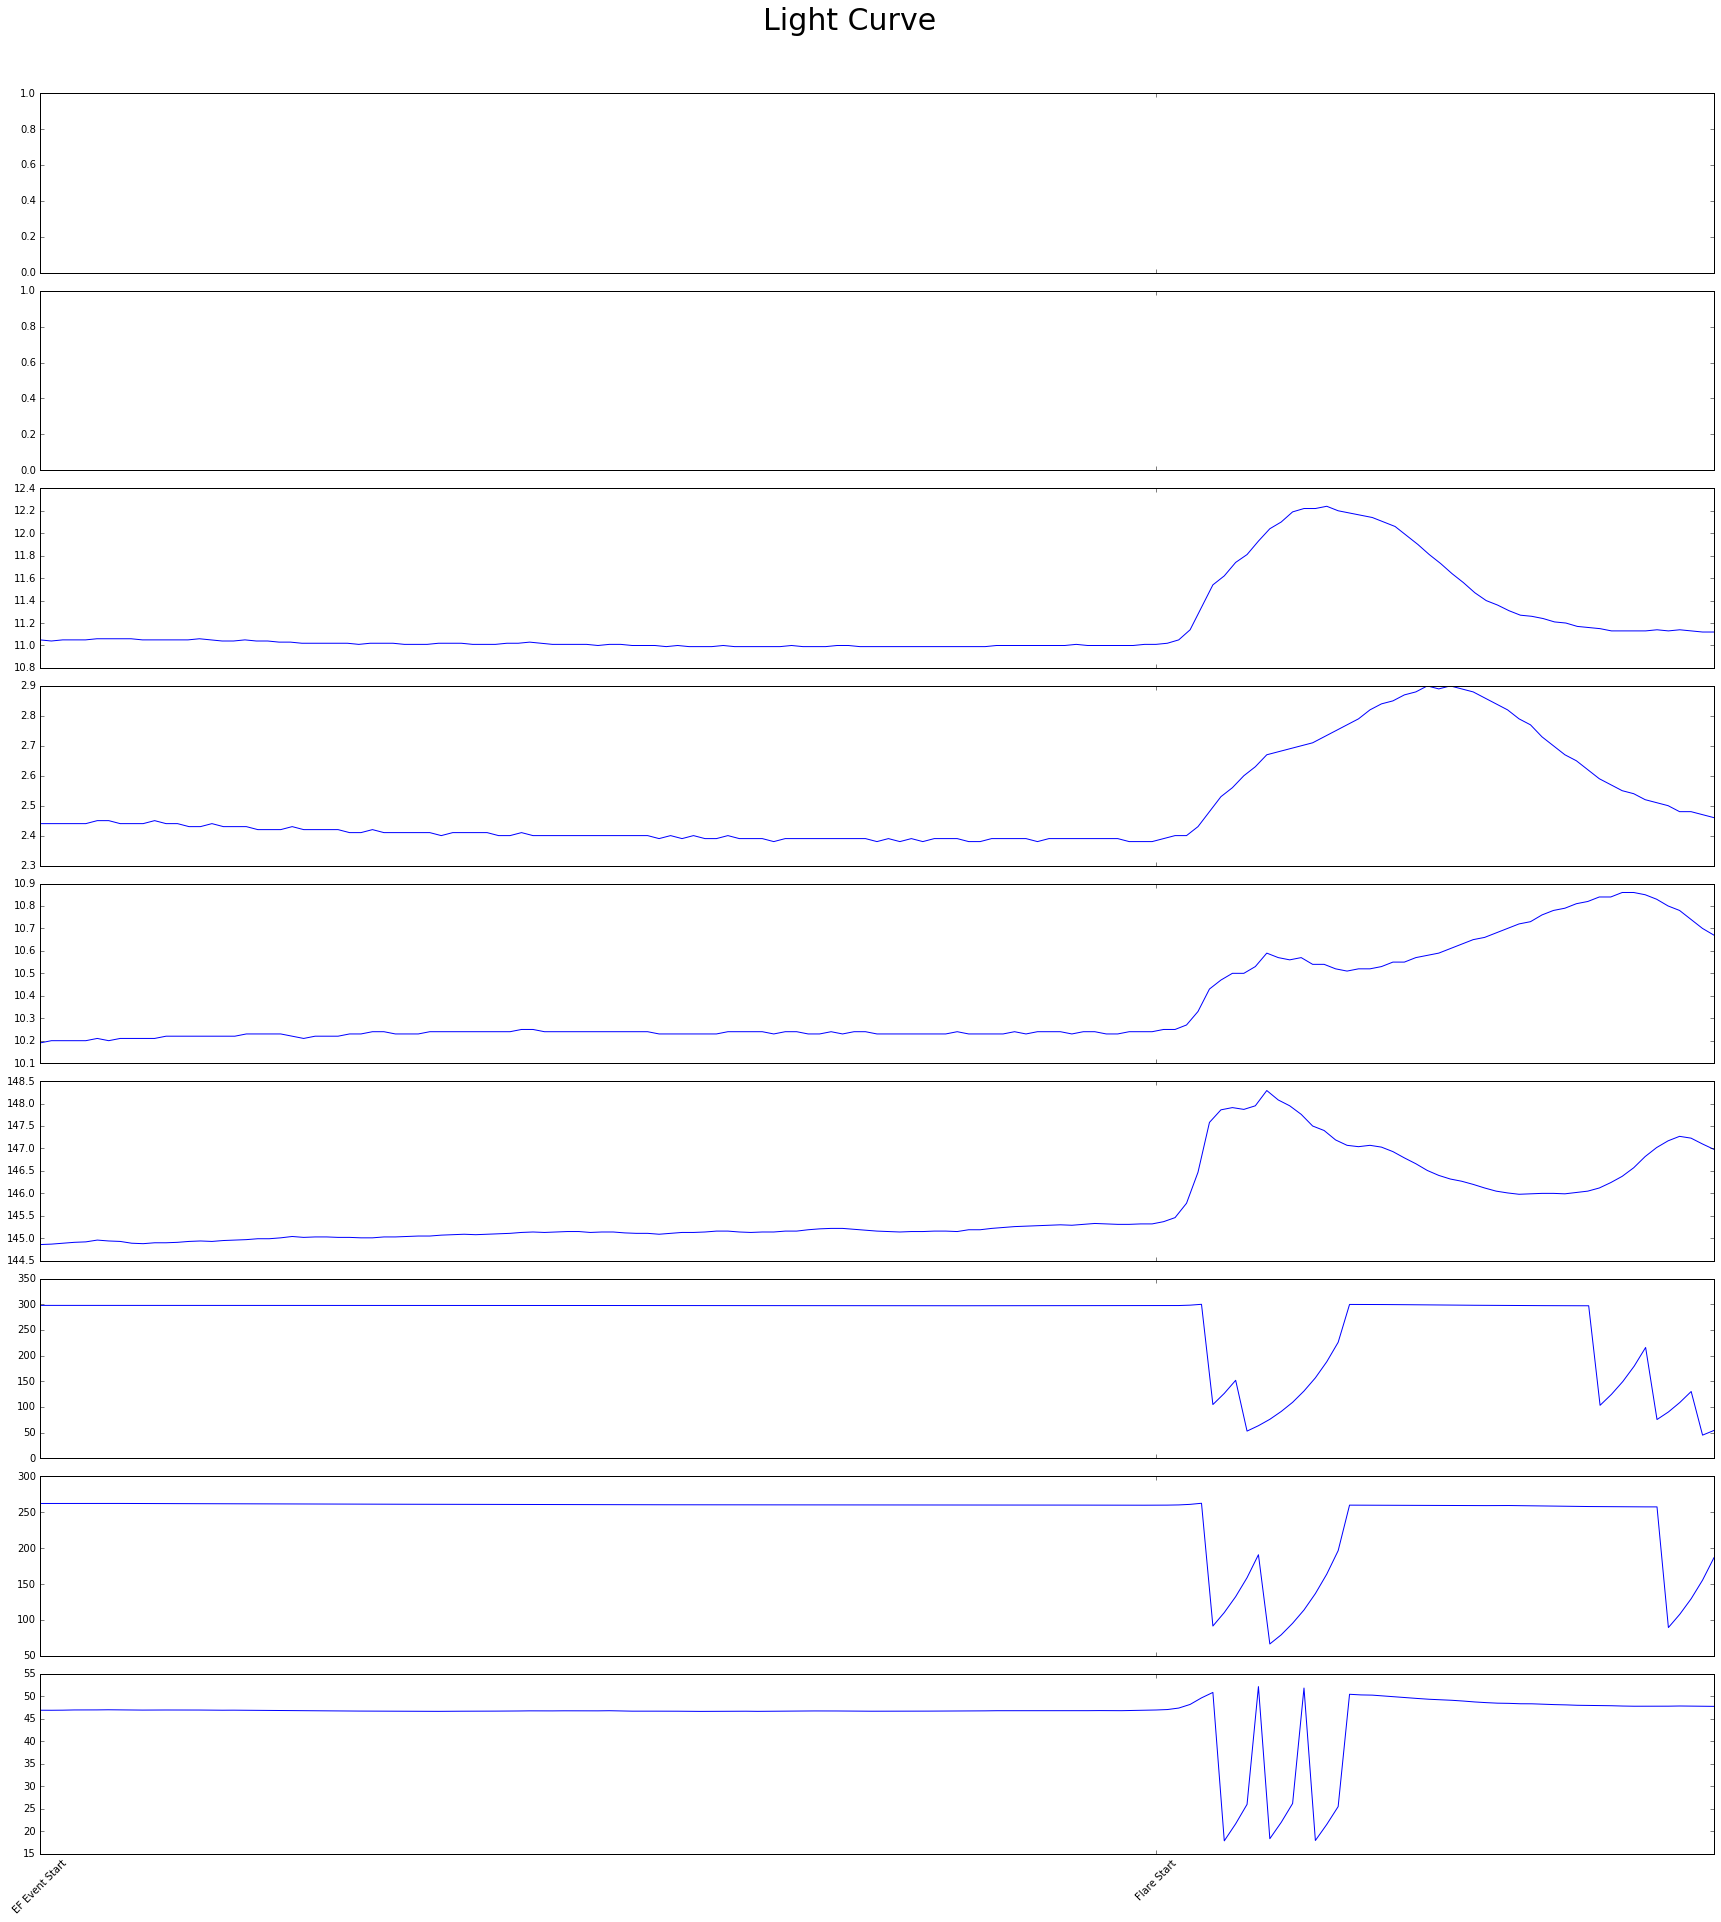

2


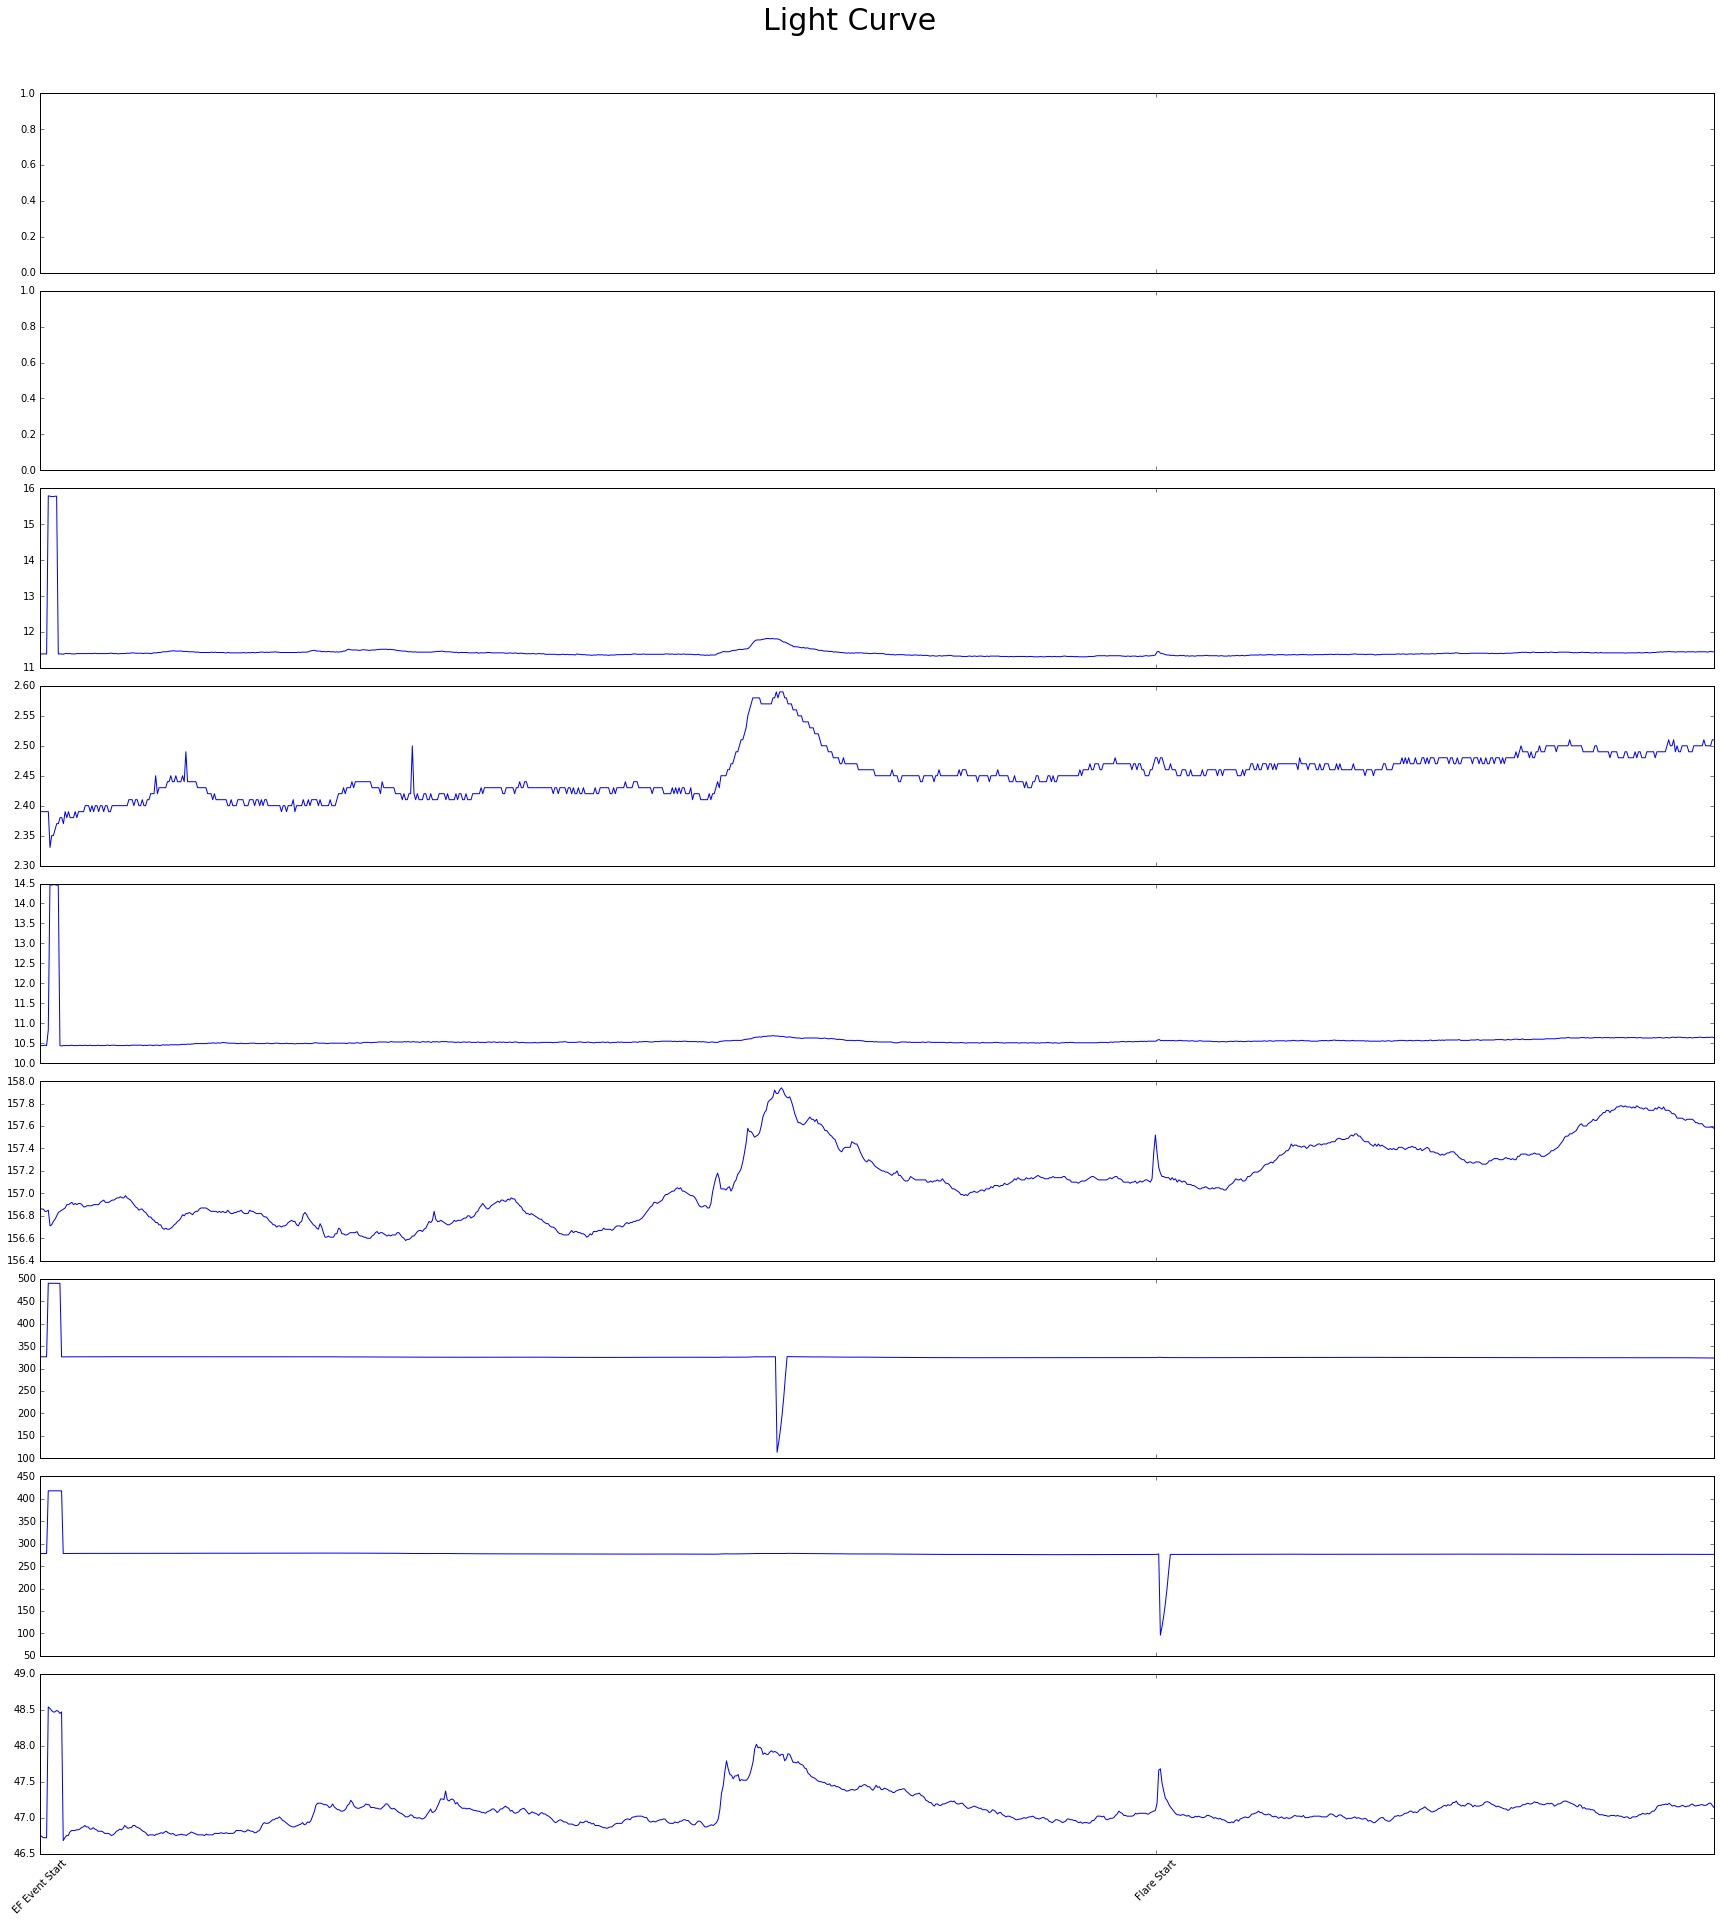

3


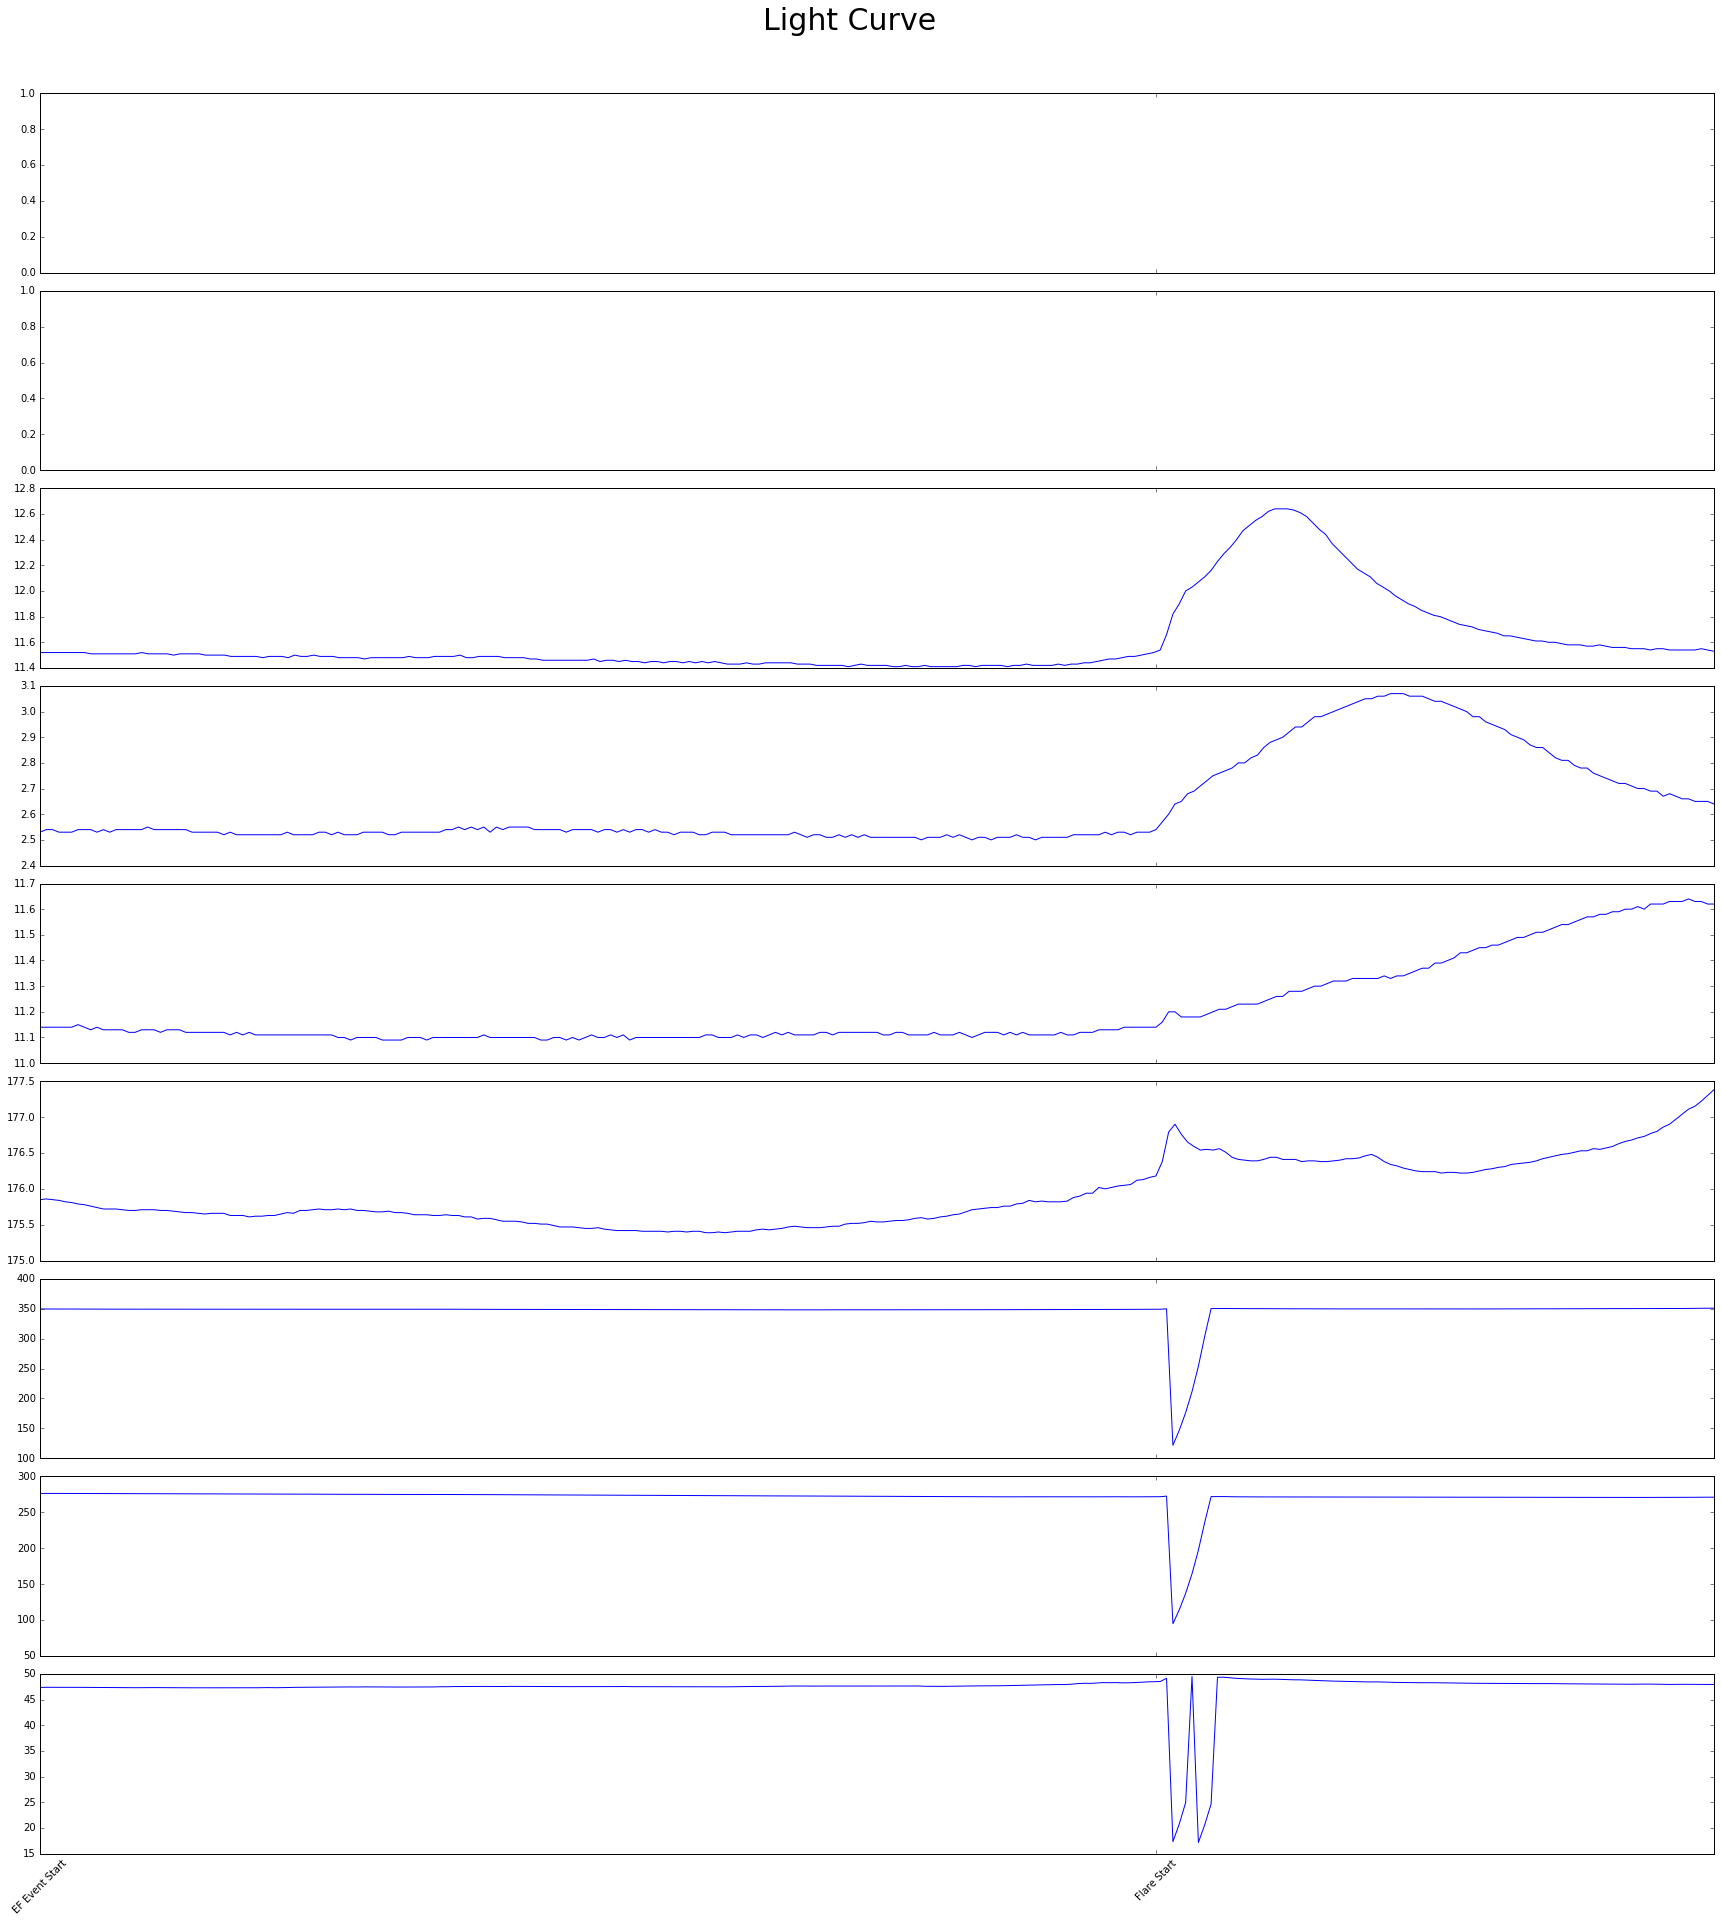

4


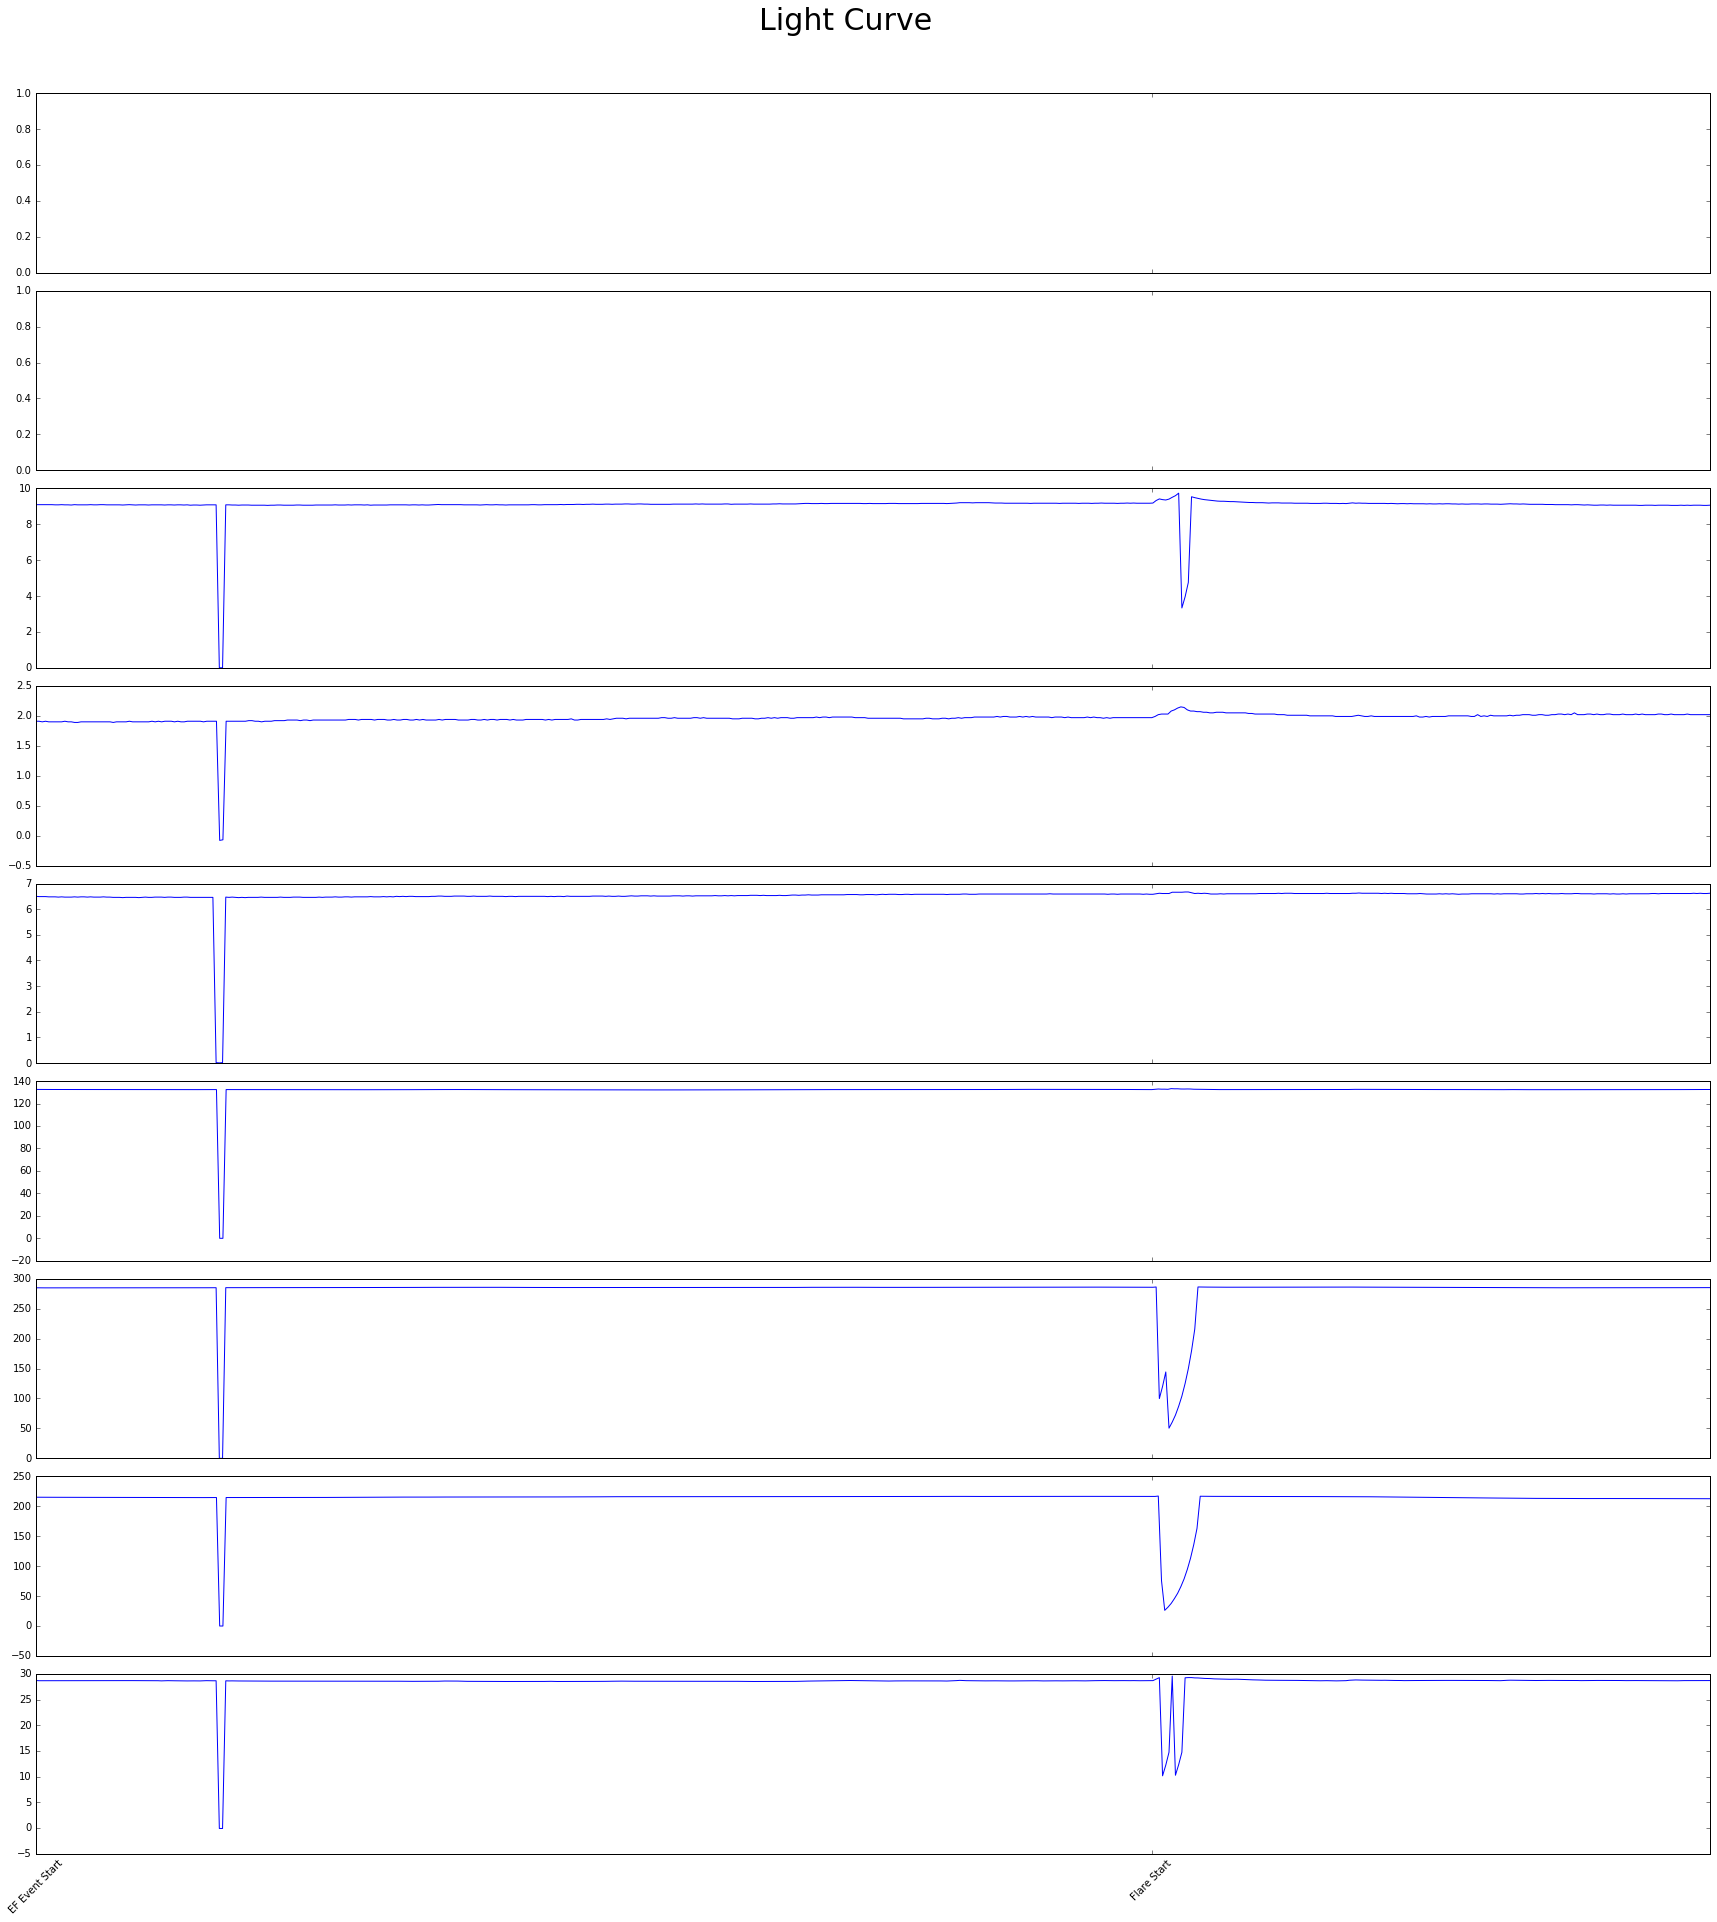

5


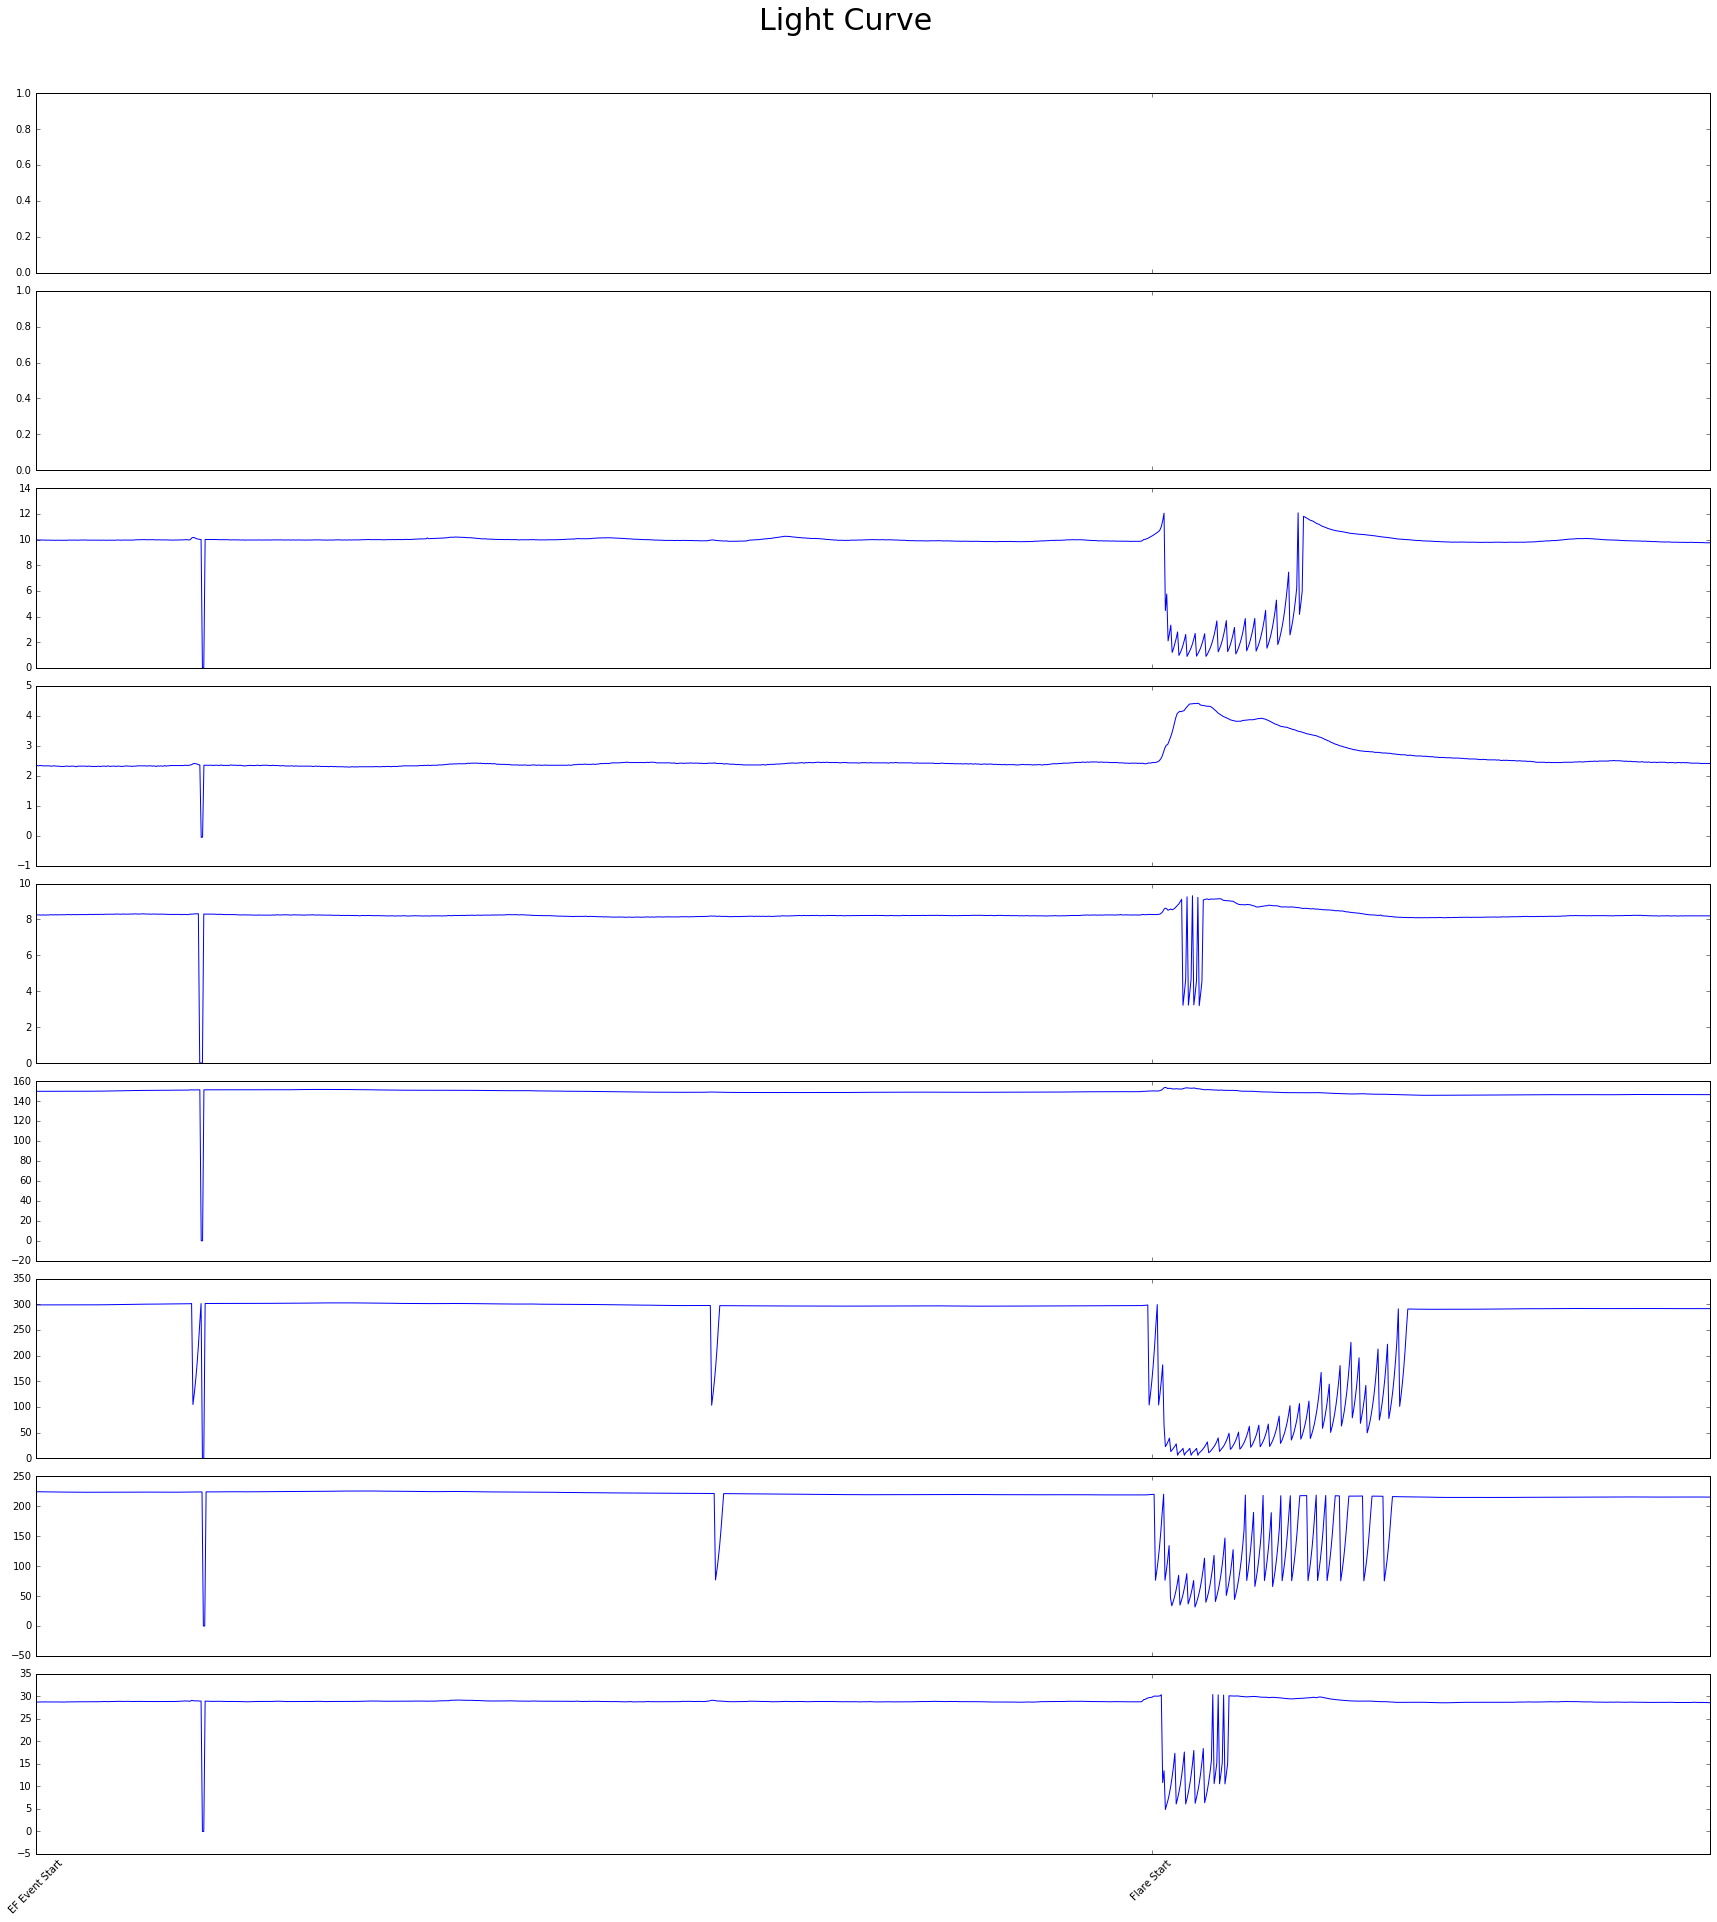

6


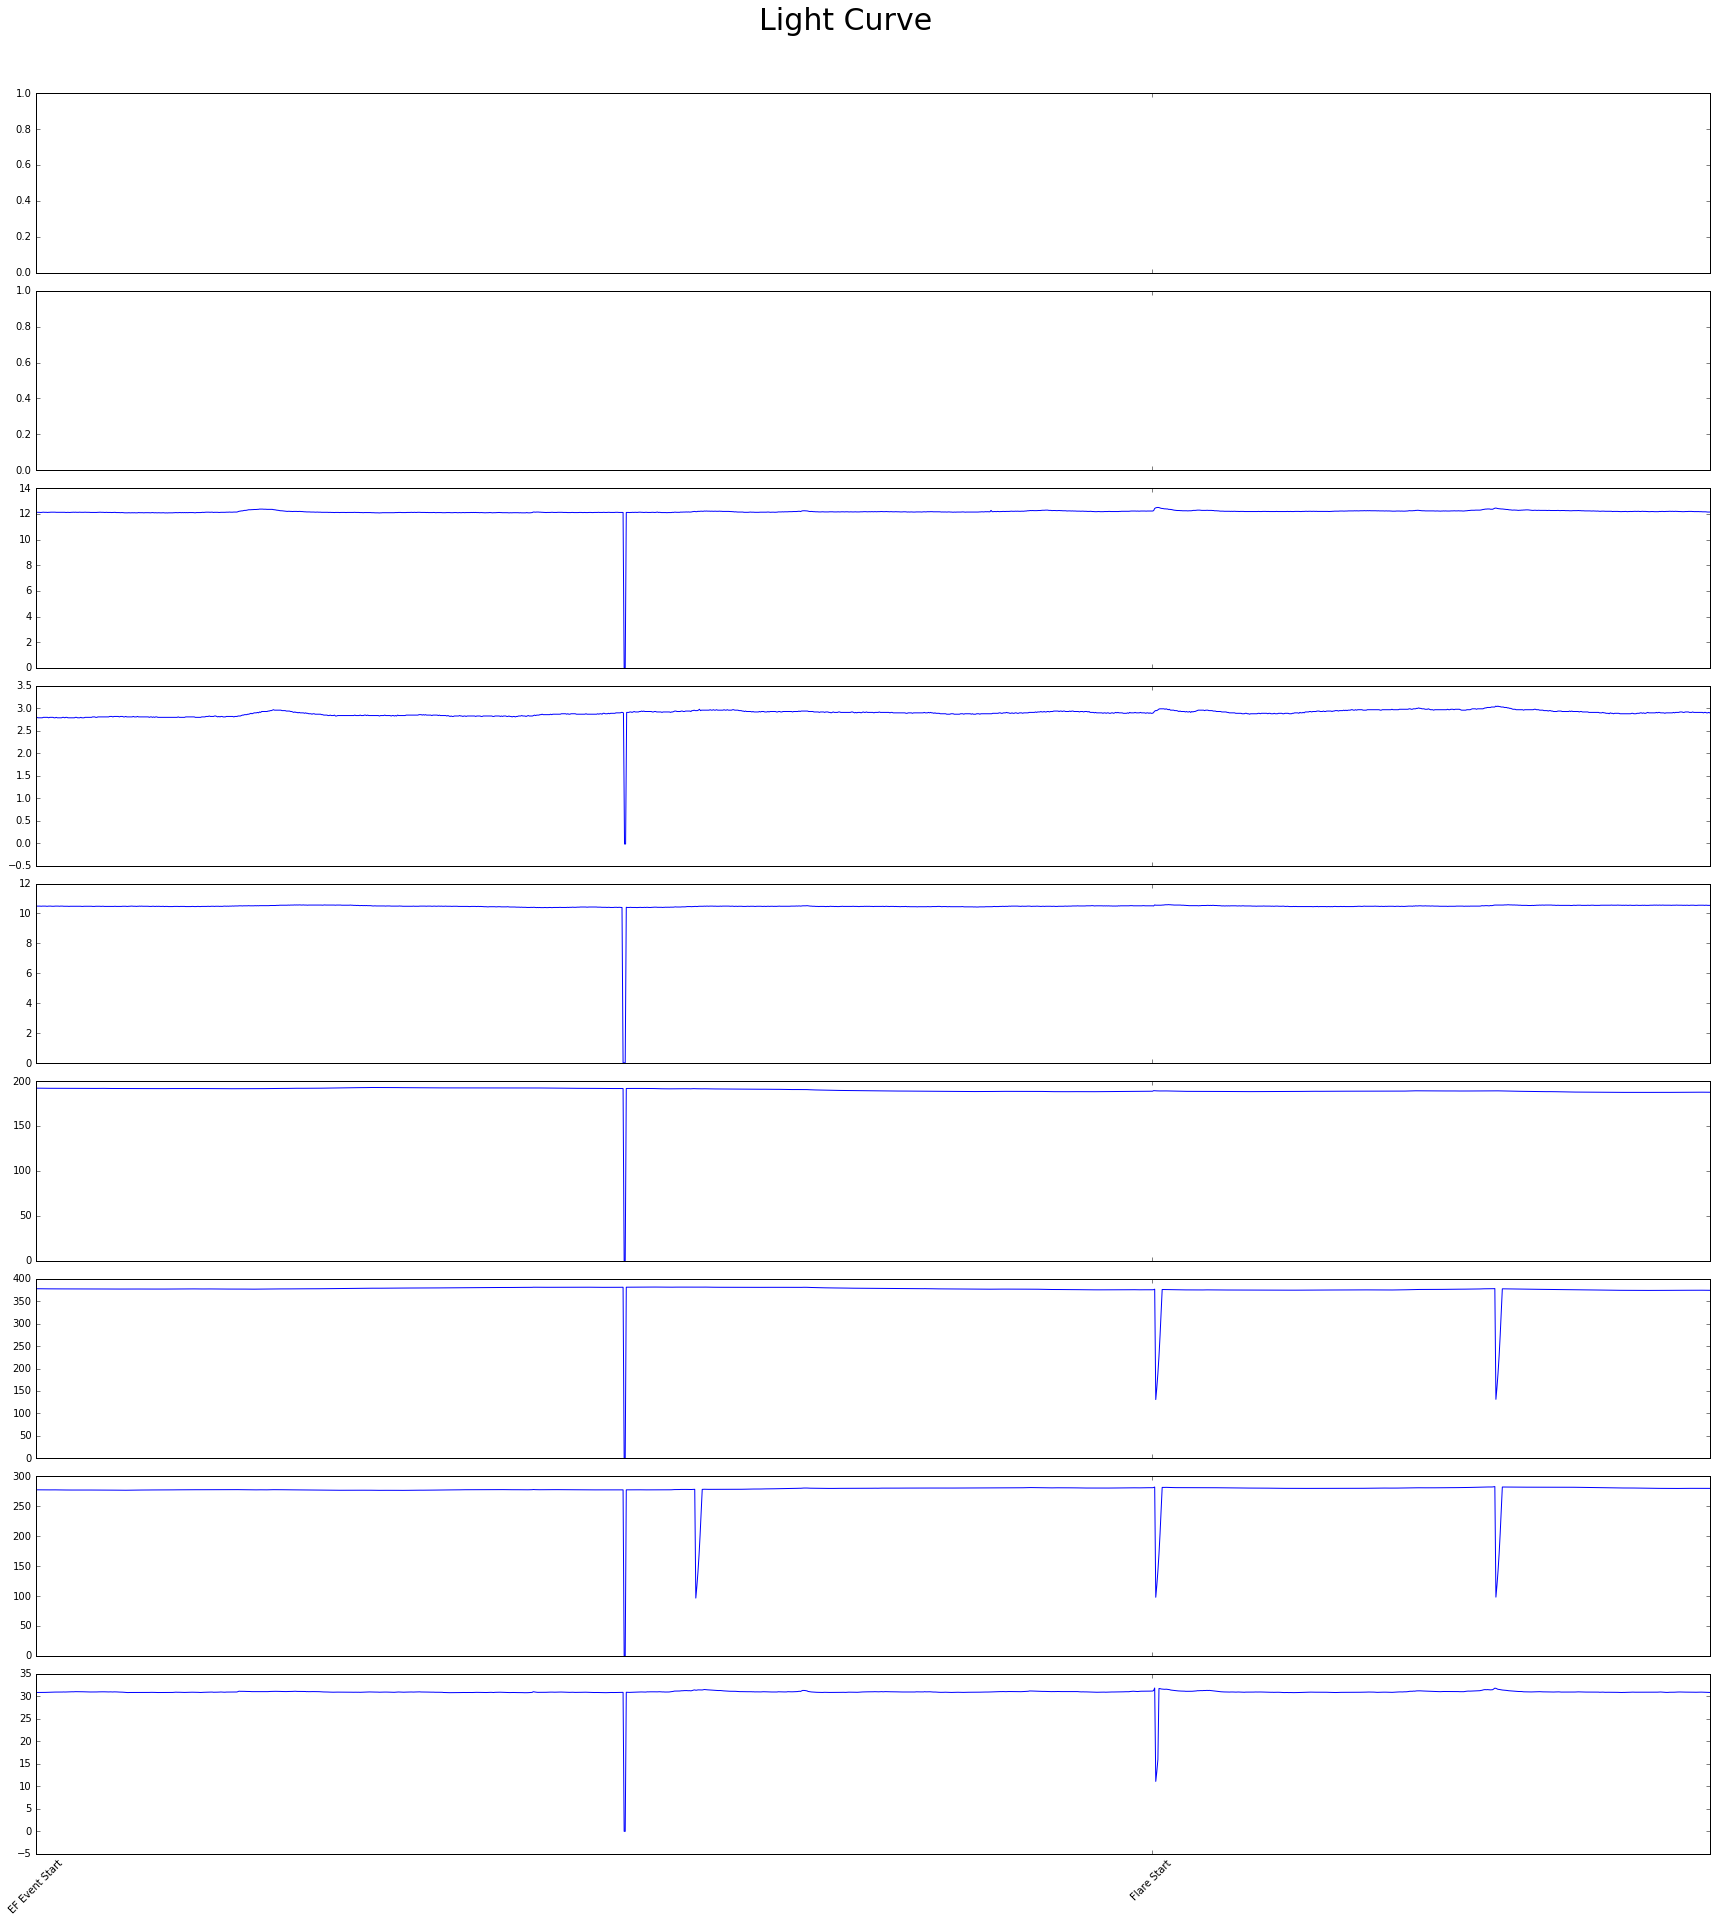

7


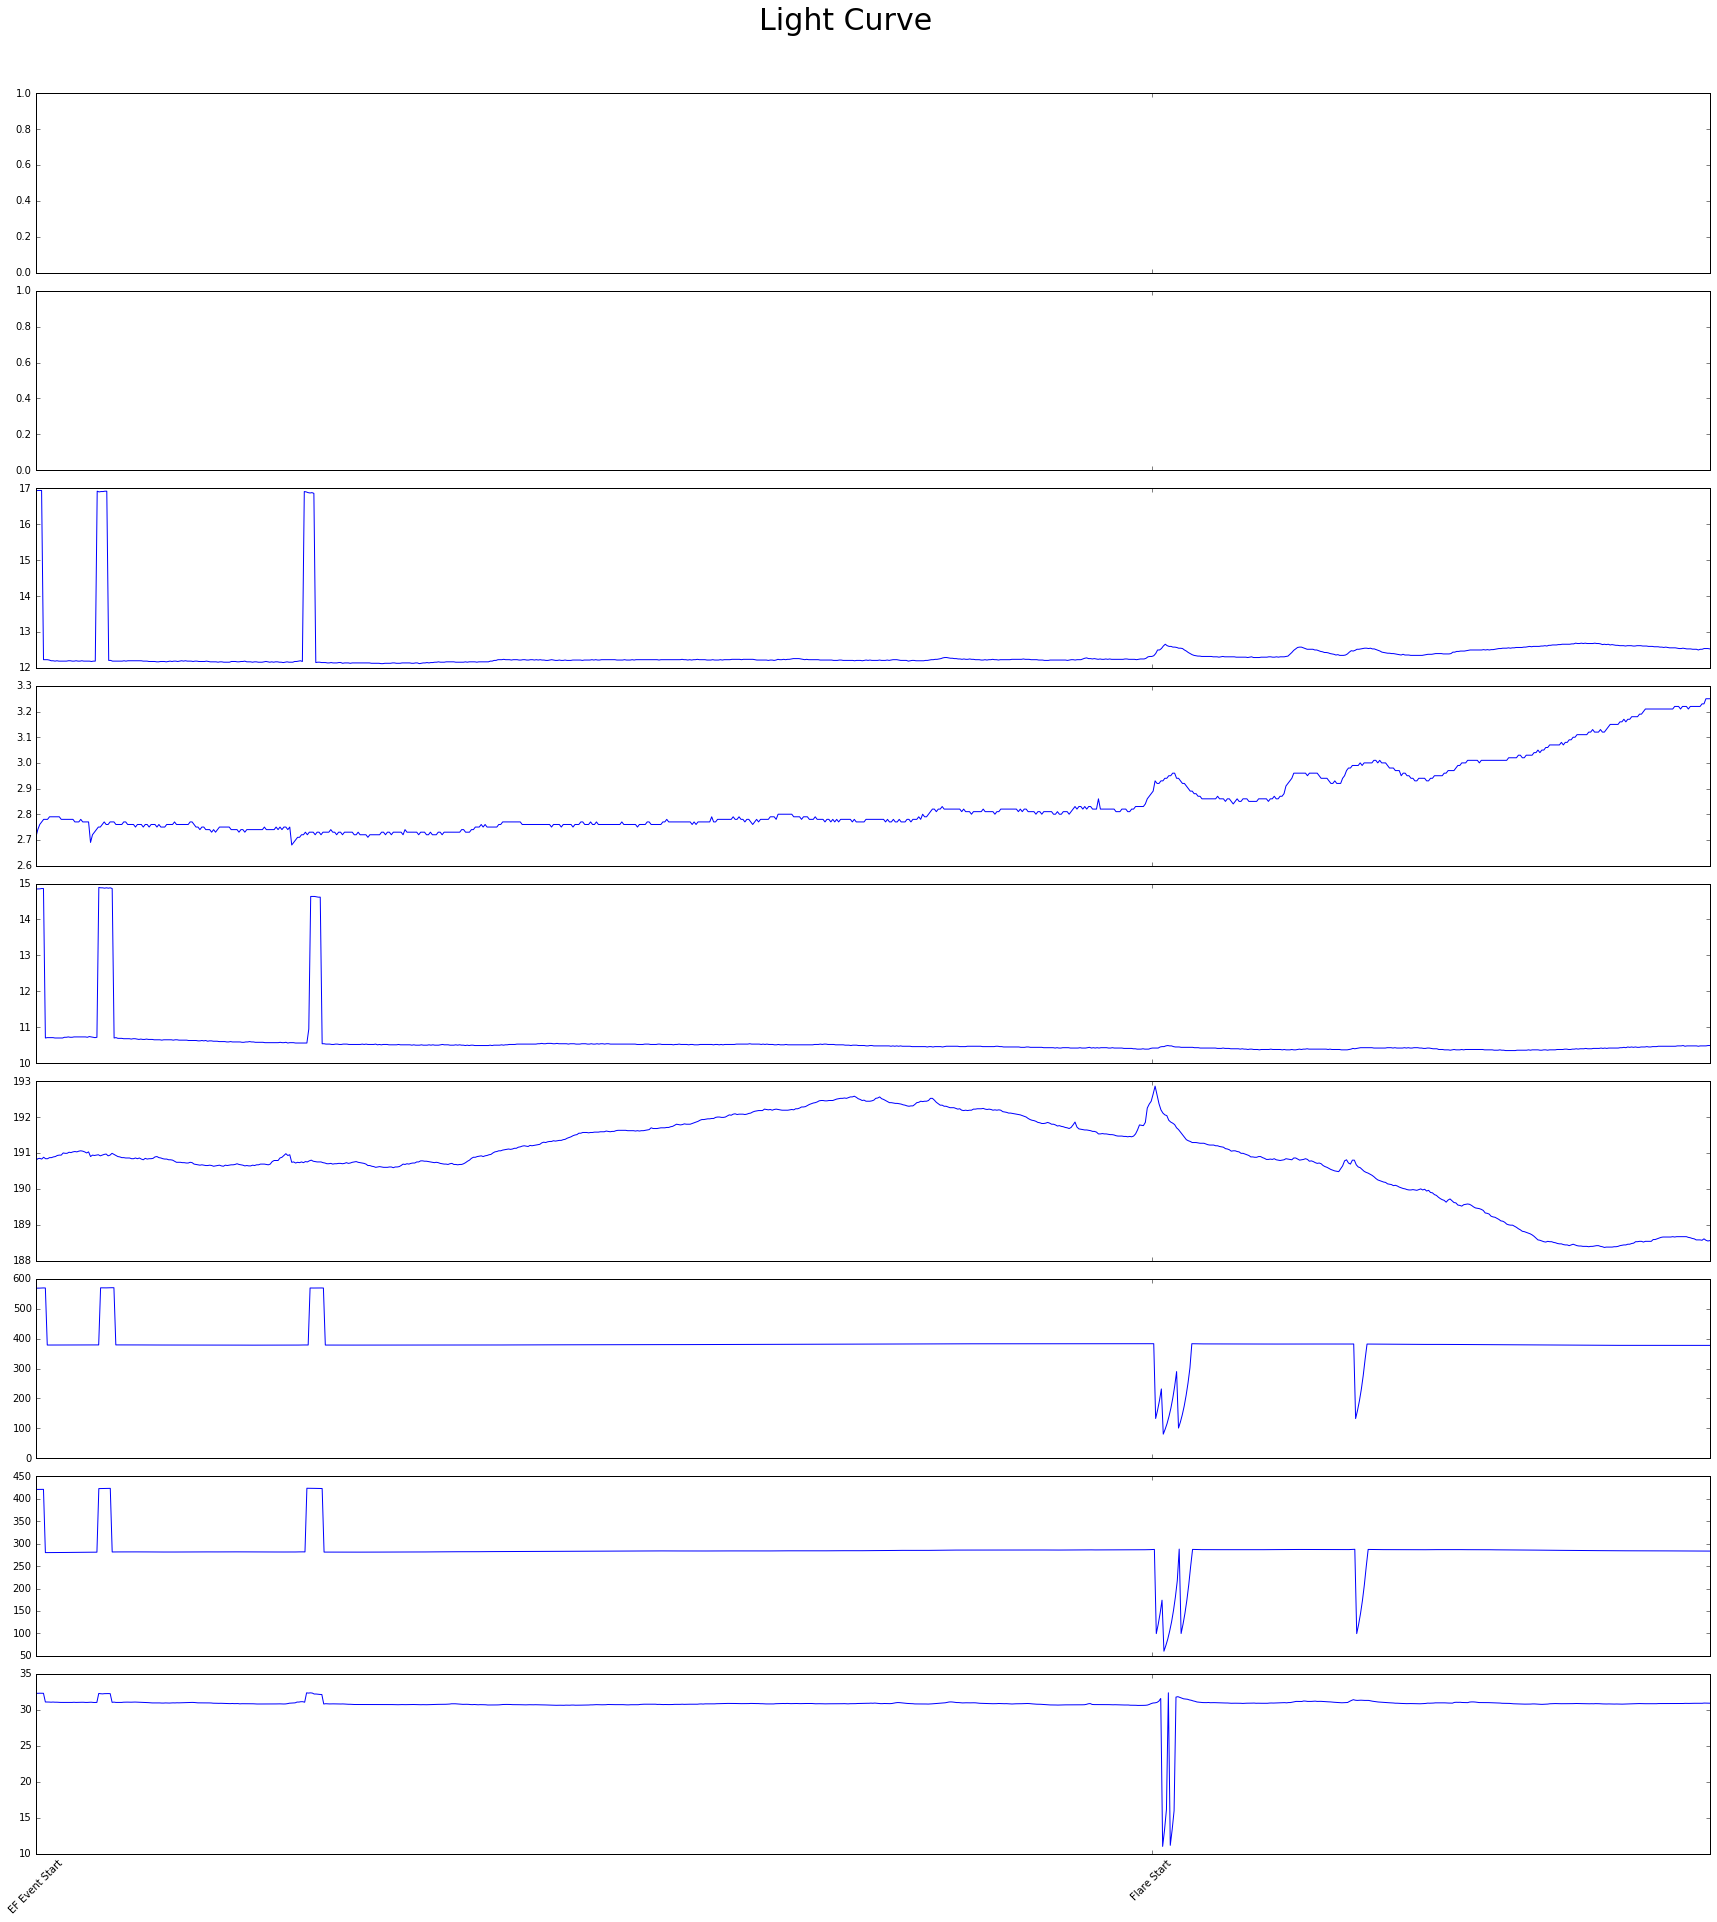

8


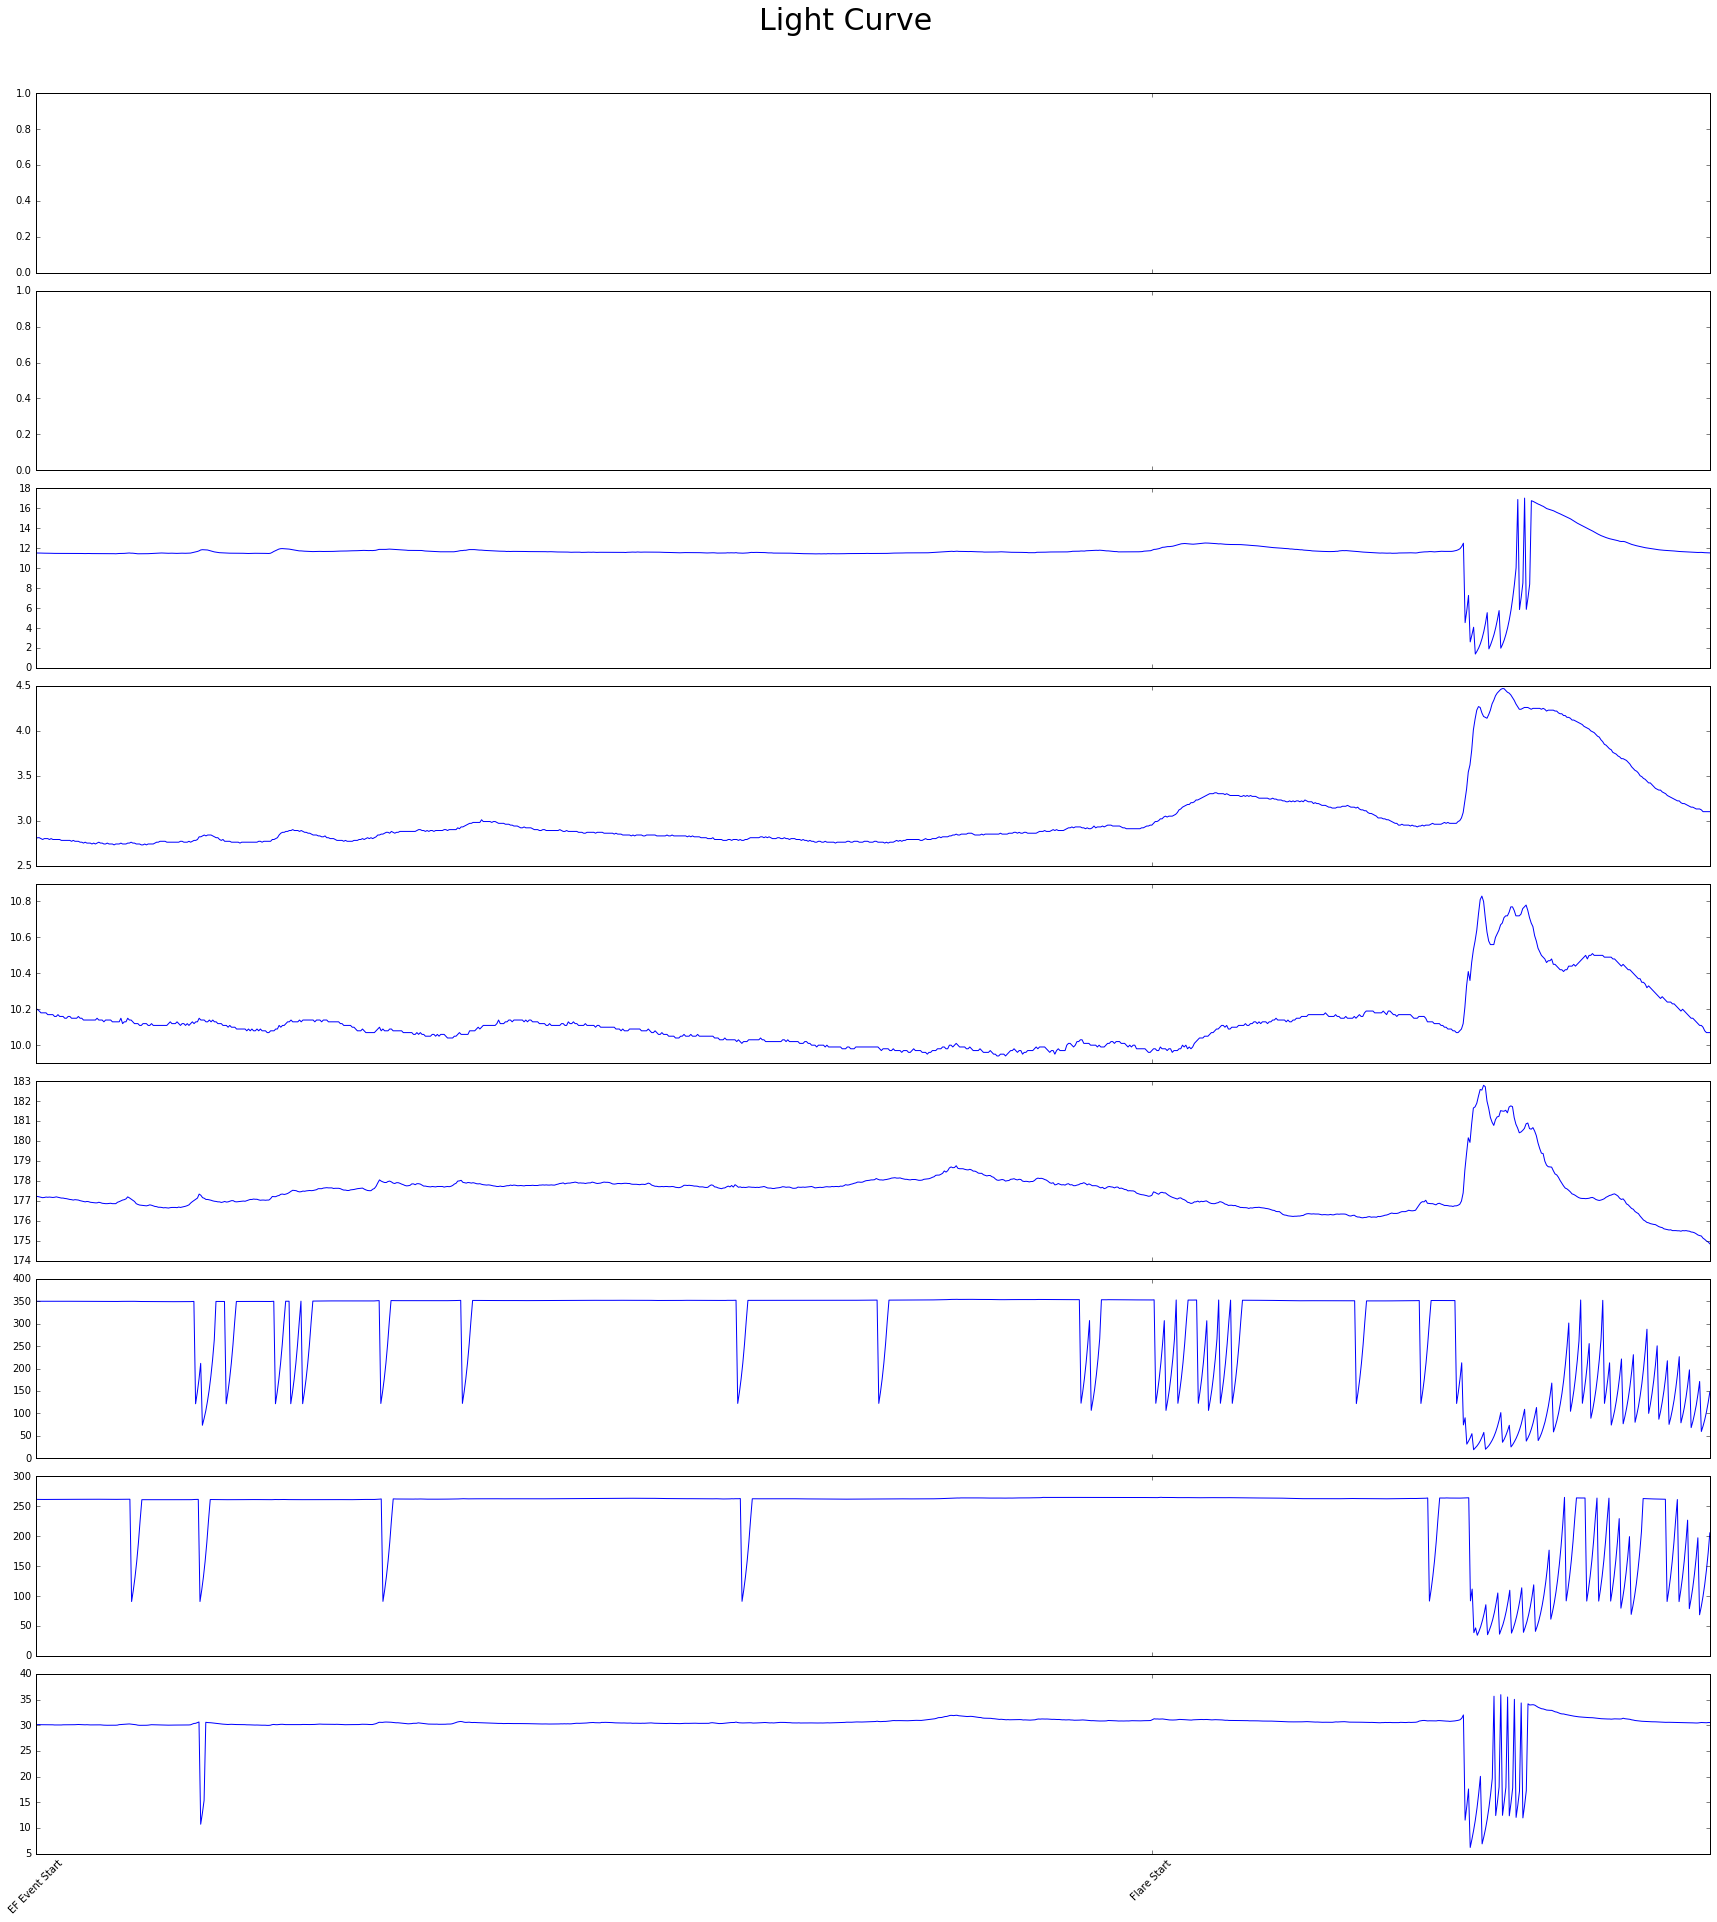

9


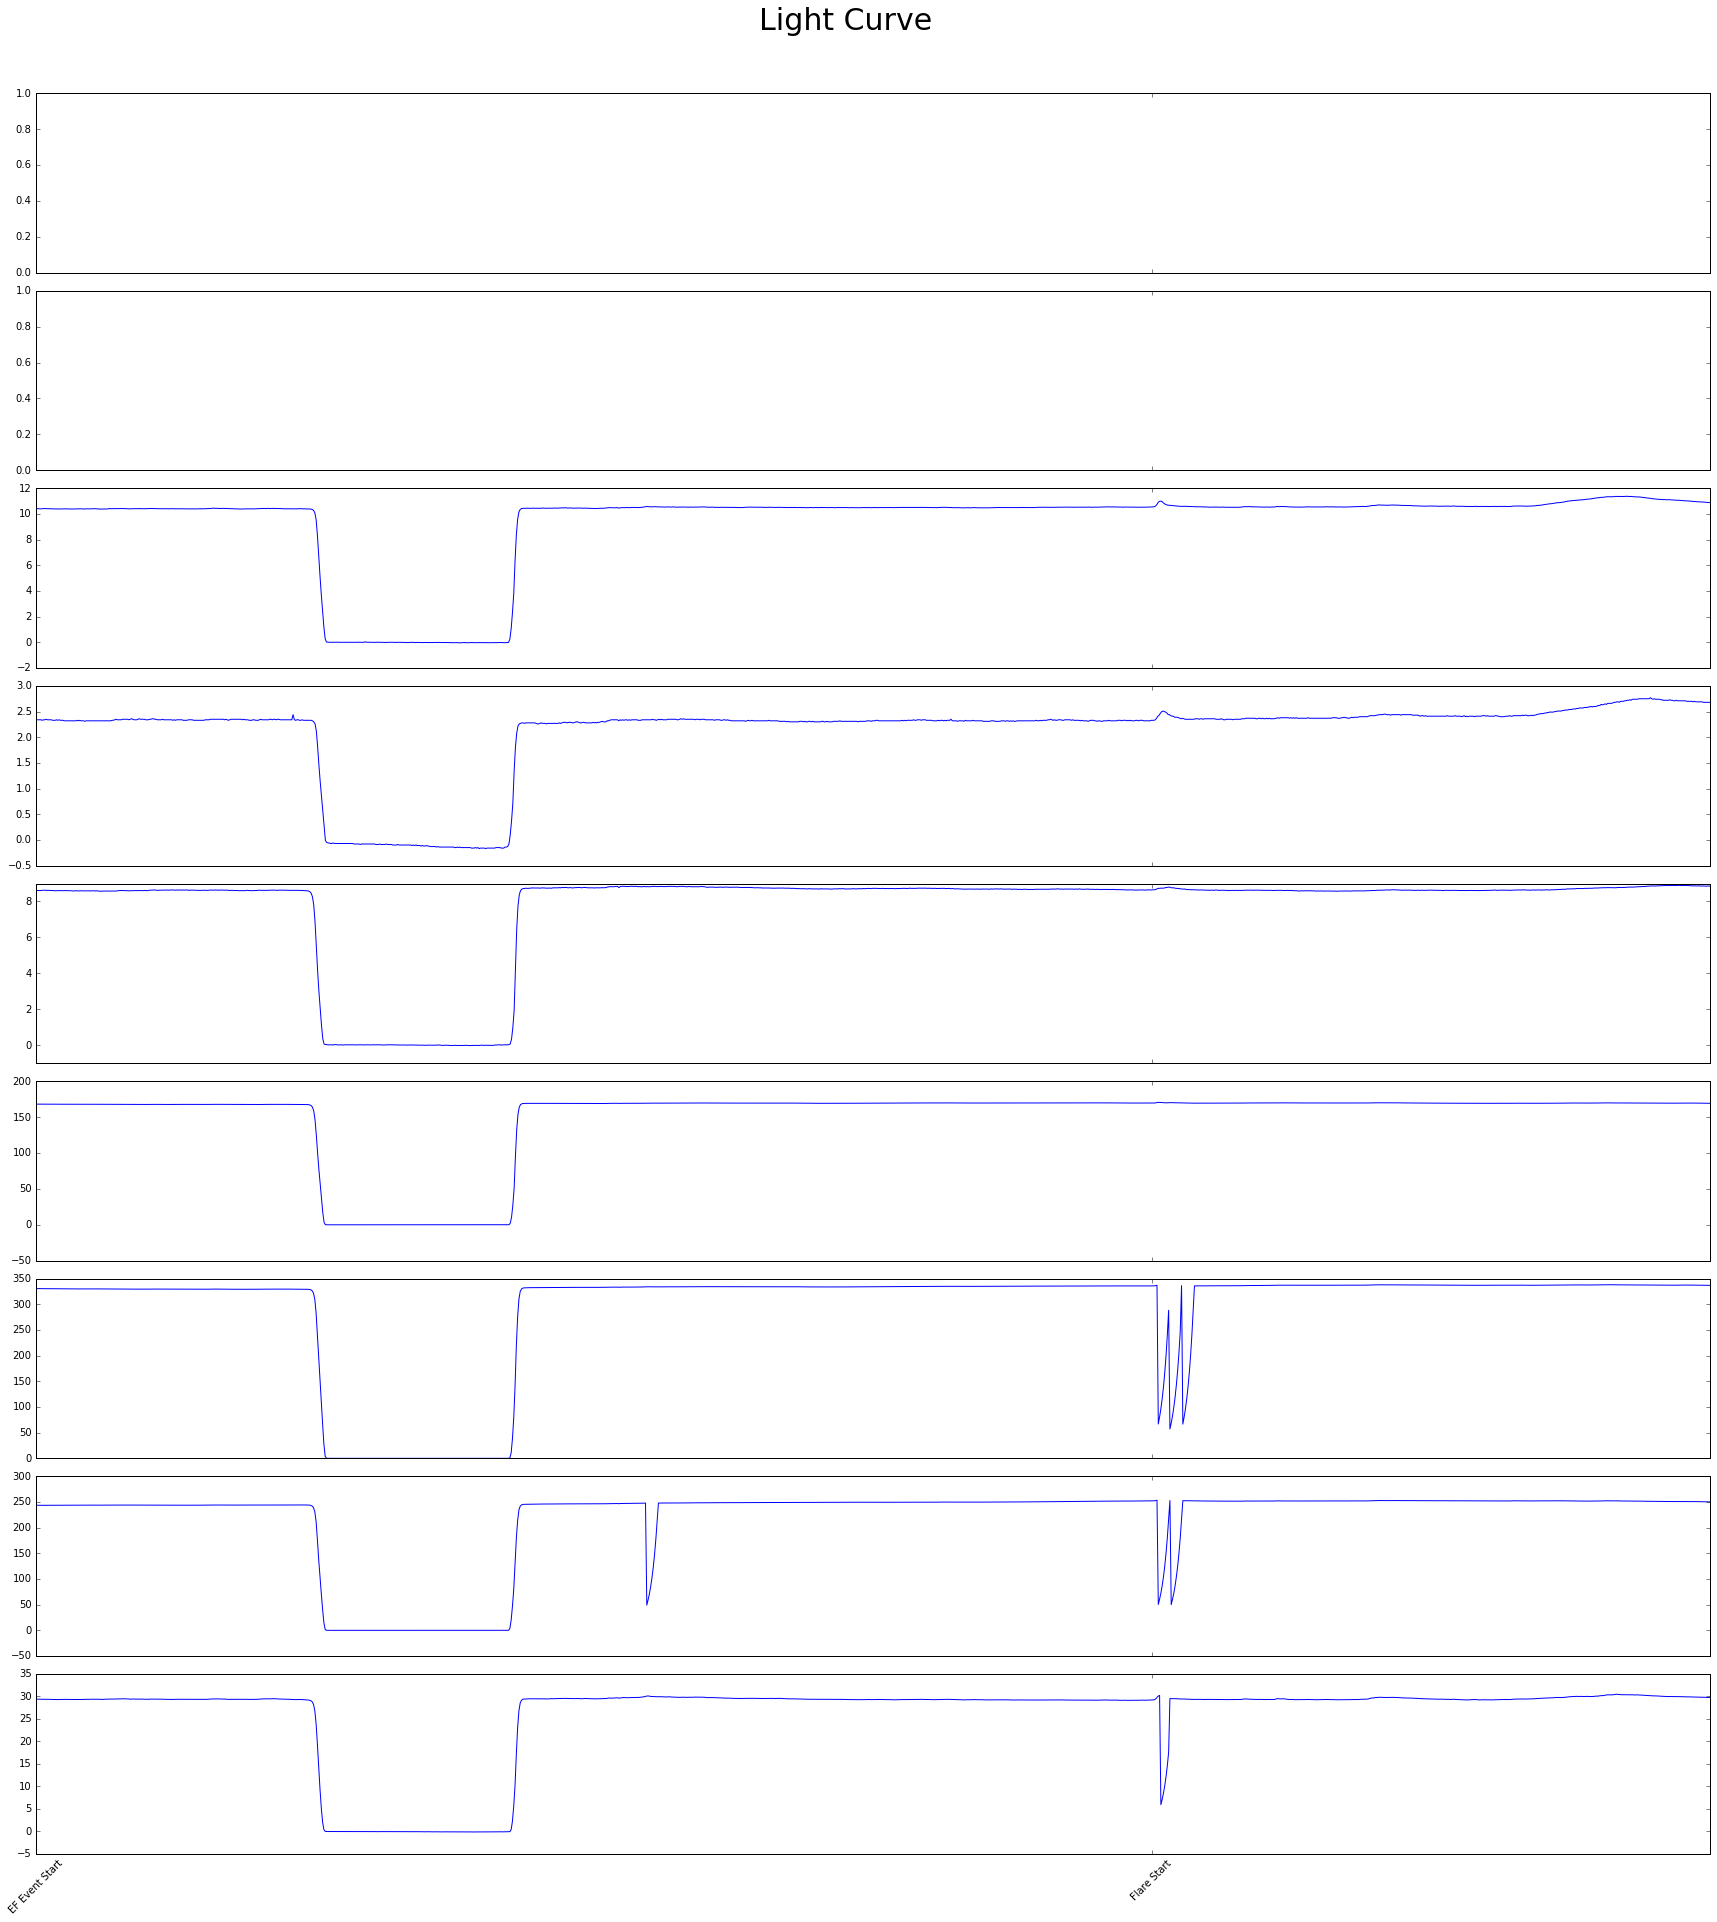

10


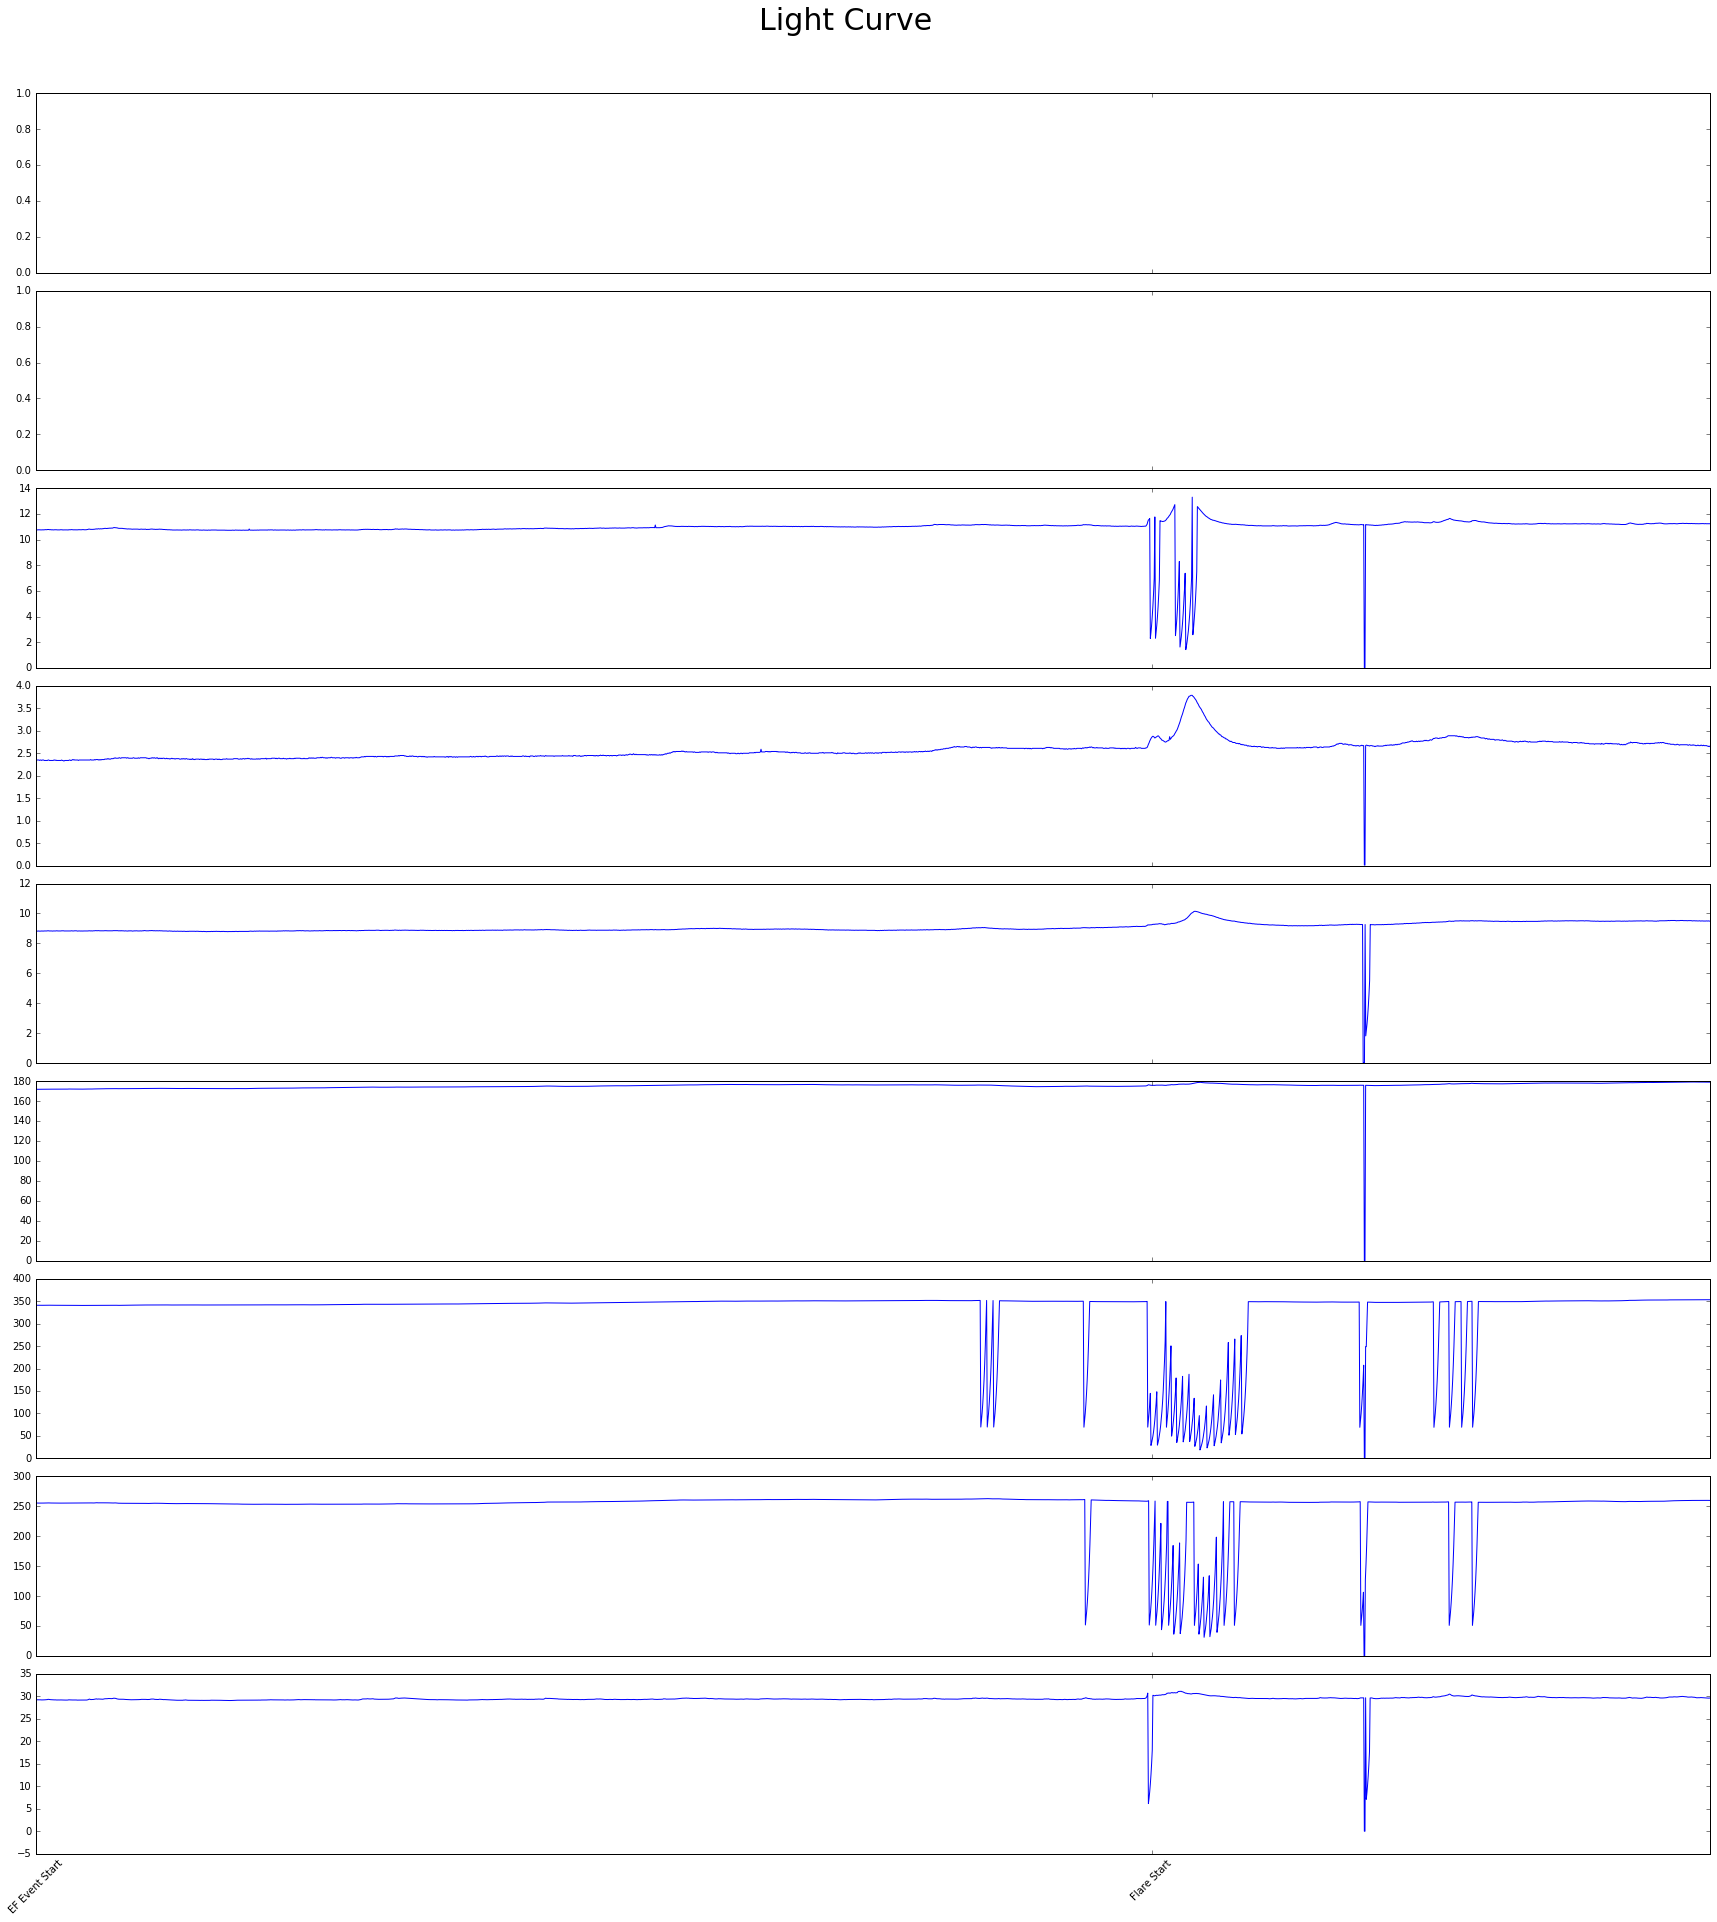

In [60]:
events = pd.read_csv('all_AIA_wavelengths_2.csv', delimiter=',', header=0)
events_ef = events.ix[events['is_ef']==1]
events_ef['ef_starttime'] = map(parse_time, events_ef['ef_starttime'])
events_ef['event_endtime'] = map(parse_time, events_ef['event_endtime'])
events_ef['event_starttime'] = map(parse_time, events_ef['event_starttime'])
start_date = datetime.datetime(2011, 3, 1)
events_ef = flares.ix[flares['event_starttime']>=start_date]

n = 201
j = 0
for elem in events_ef['ef_starttime']:
    if j<=10:
        print j
        axes = [('ax_goes1'), ('ax_goes2'), ('ax_131a'), ('ax_094a'), ('ax_335a'), ('ax_211a'), 
                    ('ax_193a'), ('ax_171a'), ('ax_304a')]
        f, axes = (plt.subplots(9, 1, sharex = 'col', figsize = (30,30)))

        colormap = plt.cm.jet
        plt.suptitle('Light Curve', fontsize = 30)
        plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9999, n)])
        yLabel = r'Flux [$W/m^2$]'
        transparency = np.linspace(0.4, 0.9, n)

        # Fine-tune figure; make subplots close to each other and hide x ticks for
        # all but bottom plot.
        f.subplots_adjust(hspace=0.1)
        f.subplots_adjust(wspace=0.05)
        f.subplots_adjust(top=0.94)

        duration = events_ef['event_starttime'].values[j] - events_ef['ef_starttime'].values[j]
        graphend = events_ef['event_starttime'].values[j] + duration*0.5
    #     minutes = (graphend - elem).total_seconds()
        for i in range(1,10):
    #         if i==1: lc = lightcurveGOESa
    #         if i==2: lc = lightcurveGOESb
            if i==3: lc = lightcurve131
            if i==4: lc = lightcurve94
            if i==5: lc = lightcurve335
            if i==6: lc = lightcurve211
            if i==7: lc = lightcurve193
            if i==8: lc = lightcurve171
            if i==9: lc = lightcurve304
            plt.subplot(9,1,i)
            if i!=1 and i!=2:
                lightcurve = get_relevant_lightcurve_AIA(elem, graphend, lc)
                length = lightcurve.shape[0]
                beginevent = 0
                endevent = 2*length/3 -1 
                indices = np.linspace(0, length, length)
                pctEvent = indices/length
                flux = map(float, lightcurve['DATAMEAN'].values)
    #                 peakflux = events_ef['fl_peakflux_131'].values[j]
    #                 percentflux = flux/peakflux
                silly = range(0, len(flux))
                plt.plot(pctEvent, flux)
            if i==0:
                plt.ylabel(yLabel, size = 'large')

            if i==9:
                plt.xticks([0, 0.666667], ('EF Event Start', 'Flare Start'), rotation = 45)
            else:plt.xticks([0, 0.666667])
            _ = plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.show()
        j+=1


In [3]:
folder = 'lightcurves_AIA_by_wavelength'

fname131 = folder+'/'+str(131)+'.csv'
fname171 = folder+'/'+str(171)+'.csv'
fname193 = folder+'/'+str(193)+'.csv'
fname211 = folder+'/'+str(211)+'.csv'
fname304 = folder+'/'+str(304)+'.csv'
fname335 = folder+'/'+str(335)+'.csv'
fname94 = folder+'/'+str(94)+'.csv'

lightcurve131 = pd.read_csv(fname131, delimiter = ',', header = 0)
lightcurve171 = pd.read_csv(fname171, delimiter = ',', header = 0)
lightcurve193 = pd.read_csv(fname193, delimiter = ',', header = 0)
lightcurve211 = pd.read_csv(fname211, delimiter = ',', header = 0)
lightcurve304 = pd.read_csv(fname304, delimiter = ',', header = 0)
lightcurve335 = pd.read_csv(fname335, delimiter = ',', header = 0)
lightcurve94 = pd.read_csv(fname94, delimiter = ',', header = 0)

lightcurve131['DATE_OBS'] = map(parse_time, lightcurve131['DATE_OBS'])
lightcurve171['DATE_OBS'] = map(parse_time, lightcurve171['DATE_OBS'])
lightcurve193['DATE_OBS'] = map(parse_time, lightcurve193['DATE_OBS'])
lightcurve211['DATE_OBS'] = map(parse_time, lightcurve211['DATE_OBS'])
lightcurve304['DATE_OBS'] = map(parse_time, lightcurve304['DATE_OBS'])
lightcurve335['DATE_OBS'] = map(parse_time, lightcurve335['DATE_OBS'])
lightcurve94['DATE_OBS'] = map(parse_time, lightcurve94['DATE_OBS'])

/usr/local/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
lightcurve_goes = pd.read_csv('raw_GOES_lightcurves.csv', delimiter = ',', header = 0)
lightcurve_goes['date'] = map(parse_time, lightcurve_goes['date'])

In [4]:
def get_relevant_lightcurve_AIA(start_time, end_time, lightcurve):
    lightcurve_search = lightcurve.ix[lightcurve['DATE_OBS']>=start_time]
    lightcurve_search = lightcurve_search.ix[lightcurve_search['DATE_OBS']<=end_time]
    return lightcurve_search

In [6]:
def integrate_lightcurve_AIA(lightcurve, start_time, end_time):
    lightcurve_search = get_relevant_lightcurve_AIA(start_time, end_time, lightcurve)
    time_zero = start_time
    delta_t =  lightcurve_search['DATE_OBS'] - time_zero
    delta_t = map(lambda x: x.total_seconds(), delta_t)
#     print '----'
#     print lightcurve_search['DATAMEAN'].values
    lightcurve_search['DATAMEAN'] = map(float_or_skip, lightcurve_search['DATAMEAN'])
#     print lightcurve_search['DATAMEAN'].values
    integrated_flux = simps(lightcurve_search['DATAMEAN'], x = delta_t)
    return integrated_flux

In [ ]:
def get_relevant_lightcurve_goes(start_time, end_time, lightcurve, a = True):
    lightcurve_search = lightcurve.ix[lightcurve['date']>=start_time]
    lightcurve_search = lightcurve_search.ix[lightcurve_search['date']<=end_time]
    return lightcurve_search

In [ ]:
def integrate_lightcurve_goes(lightcurve, start_time, end_time):
    lightcurve_search = get_relevant_lightcurve_goes(start_time, end_time, lightcurve)
    time_zero = start_time
    delta_t =  lightcurve_search['date'] - time_zero
    delta_t = map(lambda x: x.total_seconds(), delta_t)
    lightcurve_search['xrsa'] = map(float_or_skip, lightcurve_search['xrsa'])
    lightcurve_search['xrsb'] = map(float_or_skip, lightcurve_search['xrsb'])
    integrated_flux_a = simps(lightcurve_search['xrsa'], x = delta_t)
    integrated_flux_b = simps(lightcurve_search['xrsb'], x = delta_t)
    return integrated_flux_a, integrated_flux_b

In [6]:
def float_or_skip(x):
    if x!= '********':
        x = float(x)
    else: x = 0
    return x

In [7]:
flares = pd.read_csv('raw_detective.csv', delimiter = ',', header = 0)
flares['event_starttime'] = map(parse_time, flares['event_starttime'])
flares['event_endtime'] = map(parse_time, flares['event_endtime'])
zeroes = [0 for i in range(flares.shape[0])]
flares.loc[:, 'integrated_flux'] = zeroes



/usr/local/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (31,80,115) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
start_date = datetime.datetime(2011, 3, 1)
flares = flares.ix[flares['event_starttime']>=start_date]

In [10]:
i=0
for elem in flares['event_starttime']:
    wavelength = flares['obs_channelid'].values[i]
    if wavelength == 131: lc = lightcurve131
    if wavelength == 171: lc = lightcurve171
    if wavelength == 211: lc = lightcurve211
    if wavelength == 193: lc = lightcurve193
    if wavelength == 304: lc = lightcurve304
    if wavelength == 335: lc = lightcurve335
    if wavelength == 94: lc = lightcurve94
    integrated_flux = integrate_lightcurve_AIA(lc, flares['event_starttime'].values[i], 
                                               flares['event_endtime'].values[i])
    flares.loc[i, 'integrated_flux'] = integrated_flux
    i+=1
flares.to_csv('raw_detective_w_integrated_flux.csv', index=False)

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: 

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')


lightcurve_goes = pd.read_csv('raw_GOES_lightcurves.csv', delimiter = ',', header = 0,parse_dates=['date'],
                              date_parser=dateparse, usecols = ['date', 'xrsb'])

KeyboardInterrupt: 

In [5]:
length = lightcurve_goes.shape[0]
i1 = length/4
i2 = i1 - 1500
i3 = length/2
i4 = i3 -1500
i5 = length*3/4
i6 = i5 - 1500
lcg1 = lightcurve_goes.iloc[0:i1, :]
lcg1.to_csv('lightcurve_goes_1.csv', index=0, date_format = '%Y-%m-%dT%X')

In [ ]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')


lightcurve_goes = pd.read_csv('raw_GOES_lightcurves.csv', delimiter = ',', header = 0,parse_dates=['date'],
                              date_parser=dateparse, usecols = ['date', 'xrsb'])

In [ ]:
lcg2 = lightcurve_goes[i2:i3,:]
lcg2.to_csv('lightcurve_goes_2.csv', index=0, date_format = '%Y-%m-%dT%X')

In [ ]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')


lightcurve_goes = pd.read_csv('raw_GOES_lightcurves.csv', delimiter = ',', header = 0,parse_dates=['date'],
                              date_parser=dateparse, usecols = ['date', 'xrsb'])

In [ ]:
lcg3 = lightcurve_goes[i4:i5,:]
lcg3.to_csv('lightcurve_goes_3.csv', index=0, date_format = '%Y-%m-%dT%X')

In [ ]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')


lightcurve_goes = pd.read_csv('raw_GOES_lightcurves.csv', delimiter = ',', header = 0,parse_dates=['date'],
                              date_parser=dateparse, usecols = ['date', 'xrsb'])
lcg4 = lightcurve_goes[i6:-1,:]
lcg4.to_csv('lightcurve_goes_4.csv', index=0, date_format = '%Y-%m-%dT%X')